# Experimentation

## Dataset profiling

In [90]:
%matplotlib inline
import random
import math
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

import soli_start
from reviews_soli import ReviewsSolicitation
from data_model import Feature
import uncertainty

file_path = 'datasets/edmunds_reviews.csv'
dataset_profile = soli_start.probe_dataset(file_path)
print(dataset_profile)

Dataset of 5 stars, with 501 products and 53440 reviews
average of feature_rating_count/product = 77.766



Statistics of #reviews/product: min=1, max=1294, average=106.667, std=148.622, median=52.0


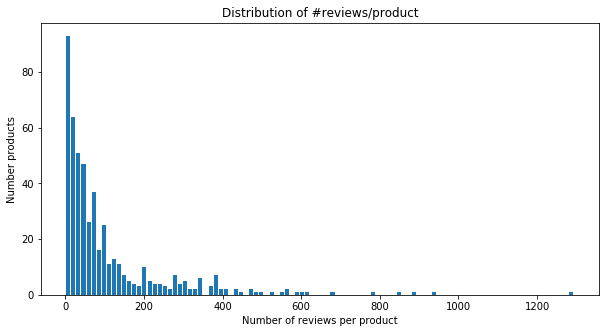

In [91]:
# Distribution of #reviews/product
temp = dataset_profile.per_product_review_counts
print('Statistics of #reviews/product: min={min}, max={max}'
      ', average={average:.3f}, std={std:.3f}, median={median}' \
      .format(min=np.amin(temp), max=np.amax(temp),
              average=np.average(temp), std=np.std(temp), median=np.median(temp)))

fig, ax = plt.subplots(figsize=(10, 5))
_ = ax.hist(dataset_profile.per_product_review_counts, bins=100, rwidth=0.8)
ax.set_xlabel('Number of reviews per product')
ax.set_ylabel('Number products')
ax.set_title('Distribution of #reviews/product')
plt.show()

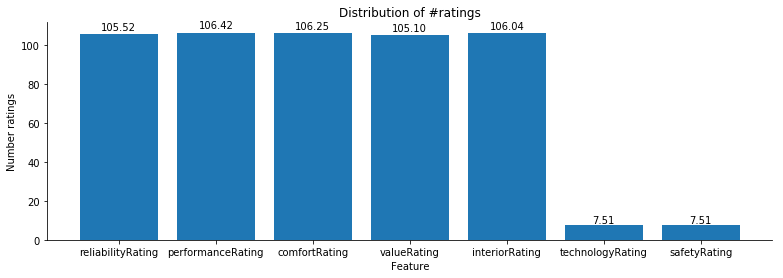

In [92]:
# Distribution of #feature_rating/product
fig, ax = plt.subplots(figsize=(13, 4))
features = list(dataset_profile.feature_to_review_count_average.keys())
num_ratings = list(dataset_profile.feature_to_review_count_average.values())
x_pos = np.arange(len(features))
rects = ax.bar(x_pos, num_ratings)

ax.set_xlabel('Feature')
ax.set_ylabel('Number ratings')
ax.set_title('Distribution of #ratings')
ax.set_xticks(x_pos)
ax.set_xticklabels(features)

for rect, num_rating in zip(rects, num_ratings):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2., 1.01*height,
            '{:.2f}'.format(num_rating), ha='center', va='bottom')
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

## Simulation

In [93]:
import pickle

from matplotlib.backends.backend_pdf import PdfPages

from uncertainty import UncertaintyMetric
import soli_start

def partition_goal_by_answer(goal_to_value):
    answer_to_goal_values = OrderedDict()
    for goal, value in goal_to_value.items():
        if goal.answer not in answer_to_goal_values:
            answer_to_goal_values[goal.answer] = OrderedDict()
        answer_to_goal_values[goal.answer][goal] = value

    return answer_to_goal_values


def plot_pick_answer_goals(goal_to_stats_average, dataset="edmunds",
                           poll_max=100, fig_w=20, fig_h=50):
    """
    Args:
        goal_to_stats_average: SoliConfig -> SimulationStats
    """
    stats_sample = list(goal_to_stats_average.values())[0]
    metrics = UncertaintyMetric.metrics()
    answer_to_goal_stats = partition_goal_by_answer(goal_to_stats_average)
    
    subpl_col_count = 2
    subpl_row_count = len(metrics) if dataset == "edmunds" \
                                   else math.ceil(len(metrics) / subpl_col_count)

    X = list(stats_sample.polls)[1:poll_max]
    fig, axarr = plt.subplots(subpl_row_count, subpl_col_count,
                              figsize=(fig_w, fig_h),
                              subplot_kw=dict(xlabel='Number of polls'))  
    subpl_idx = 0
    for metric_idx, metric in enumerate(metrics):        
        for answer, goal_to_stats_average in answer_to_goal_stats.items():
            # each goal is plotted by a curve
            for goal, stats in goal_to_stats_average.items():
                ax = axarr[subpl_idx // subpl_col_count, subpl_idx % subpl_col_count]
                if goal.optm_goal \
                        and goal.optm_goal not in UncertaintyMetric.optm_goals()[:-1]:
                    continue
                Y = [report.get_metric(metric)
                     for report in stats.uncertainty_reports[1:poll_max]]
                ax.plot(X, Y, label=goal.pick_goal_str())
                
                ax.set_title('Cost change over polls ({})'.format(answer))
                ax.set_ylabel(str(metric))
                ax.legend(loc='upper right')
            subpl_idx += 1

    plt.show()
    return fig

def plot_ratings(goal_to_stats_average, dataset="edmunds",
                 polls=[50, 100], fig_w=20, fig_h=20):

    answer_count = 2 if dataset == "edmunds" else 1
    subpl_col_count = 2    
    # When there's only 1 answer mth, still stack 2 subplot on a row
    subpl_row_count = math.ceil(len(polls) / (subpl_col_count / answer_count))
   
    fig, axarr = plt.subplots(subpl_row_count, subpl_col_count,
                              figsize=(fig_w, fig_h), sharey=True,
                              subplot_kw=dict(xlabel='Number of ratings'))
    features = list(goal_to_stats_average.values())[0].features
    
    bar_gap = 6
    Y = np.arange(len(goal_to_stats_average) / answer_count, 0, -1) * bar_gap
    width = bar_gap / (1 + len(features))

    answer_to_goal_stats = partition_goal_by_answer(goal_to_stats_average)
    subpl_idx = 0
    for poll in polls:
        for answer, goal_to_stats in answer_to_goal_stats.items():
            if subpl_row_count == 1:
                ax = axarr[subpl_idx]
            else:
                ax = axarr[subpl_idx // subpl_col_count, subpl_idx % subpl_col_count]
            # plot each goal's stats by a set of horizontal bars
            for feature in features:
                X = [np.sum(stats_average.poll_to_ratings[poll][feature.idx, :])
                     for stats_average in goal_to_stats.values()]                                
                Y_pos = Y - feature.idx * width
                ax.barh(Y_pos, X, width, label=feature.name)

            Y_pos_mid = Y - len(features) / 2 * width
            ax.set_yticks(Y_pos_mid)
            ax.set_yticklabels([goal.pick_goal_str()
                                         for goal in goal_to_stats.keys()])
            ax.set_title("Rating distribution after {} polls ({})".format(
                poll, answer))
            ax.legend(loc='upper right')
            
            if answer_count == 2:
                subpl_idx += 1
        
        if answer_count != 2:
            subpl_idx += 1

    plt.show()
    return fig

------------------------output/edmunds_l300_p300_q2.pickle------------------------



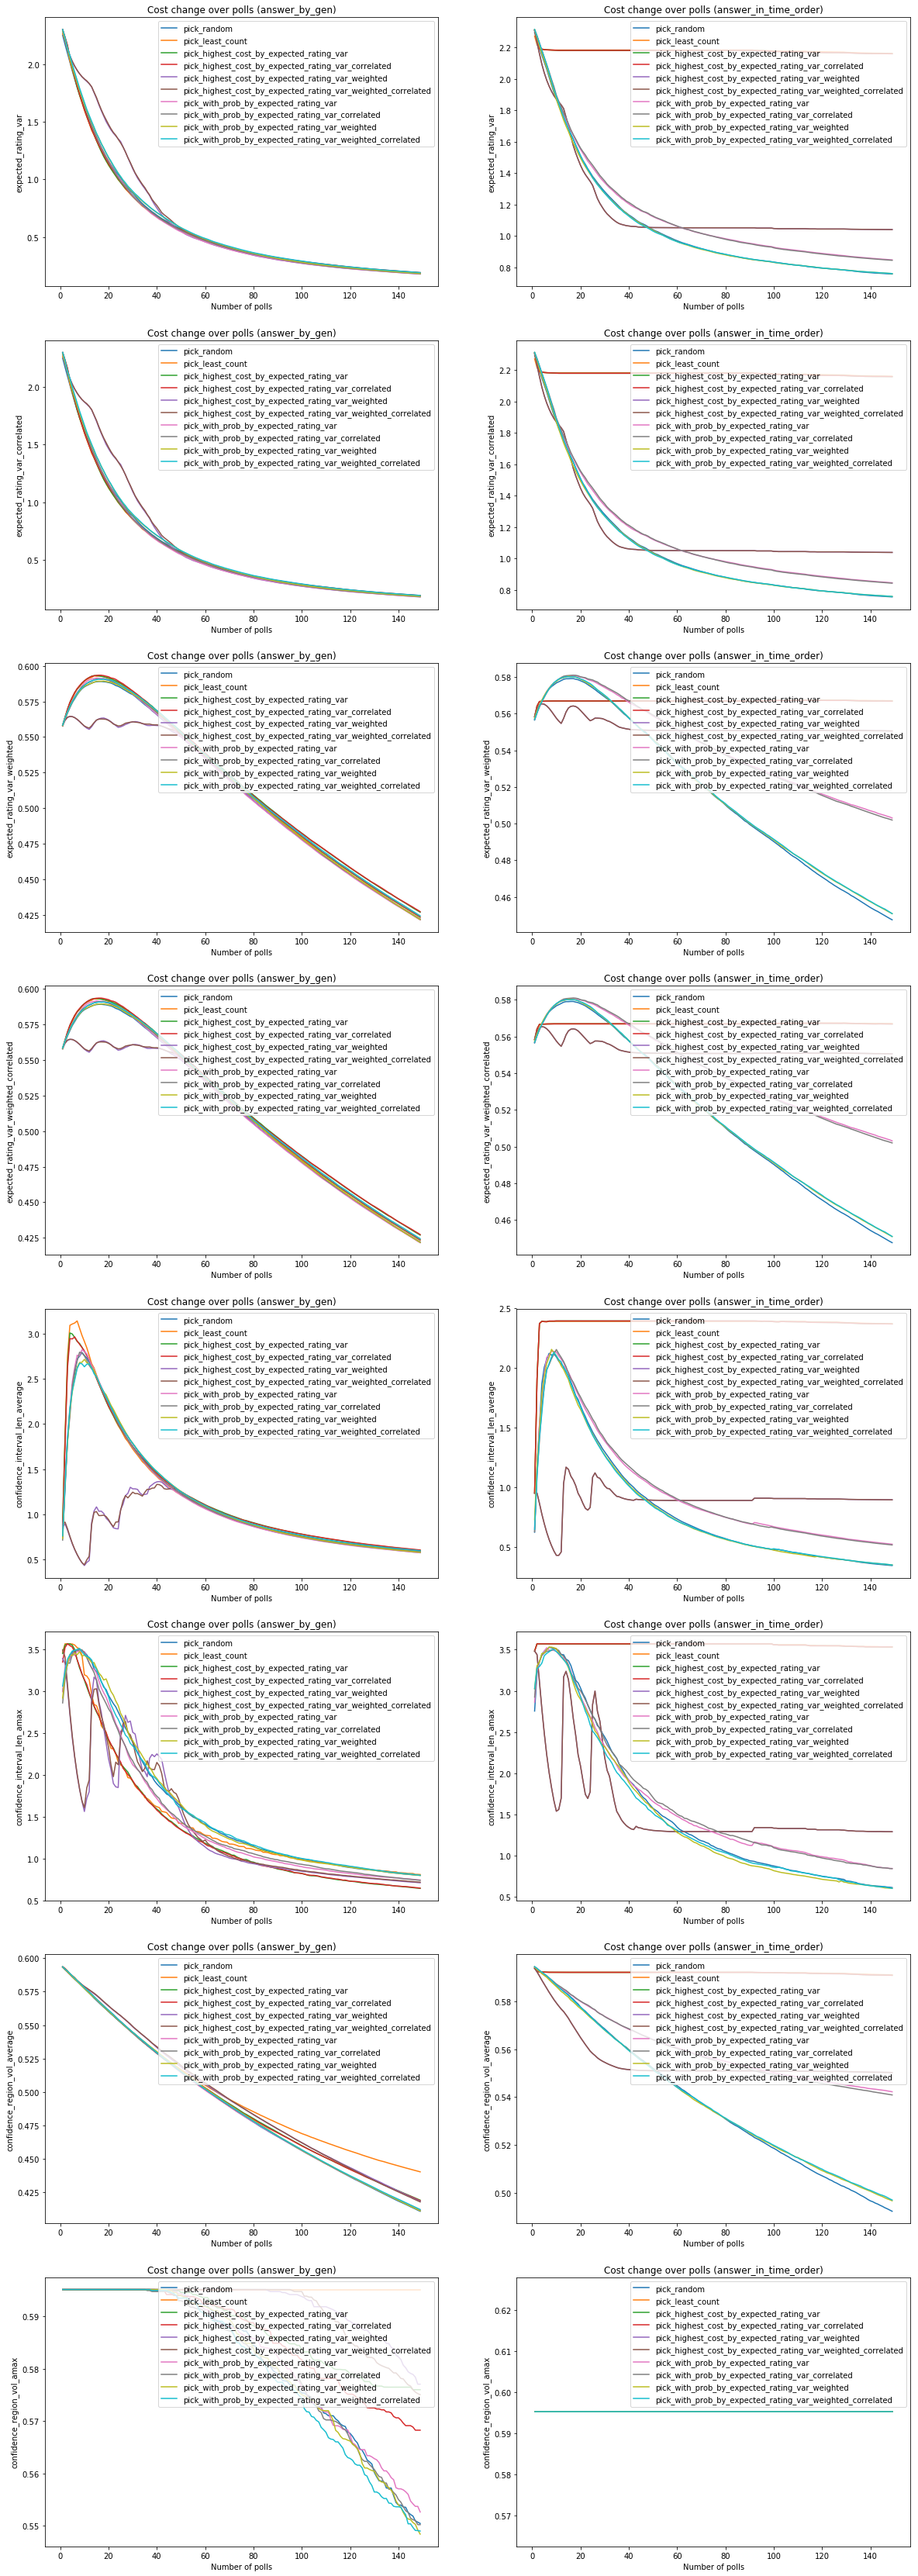

------------------------Rating distribution------------------------



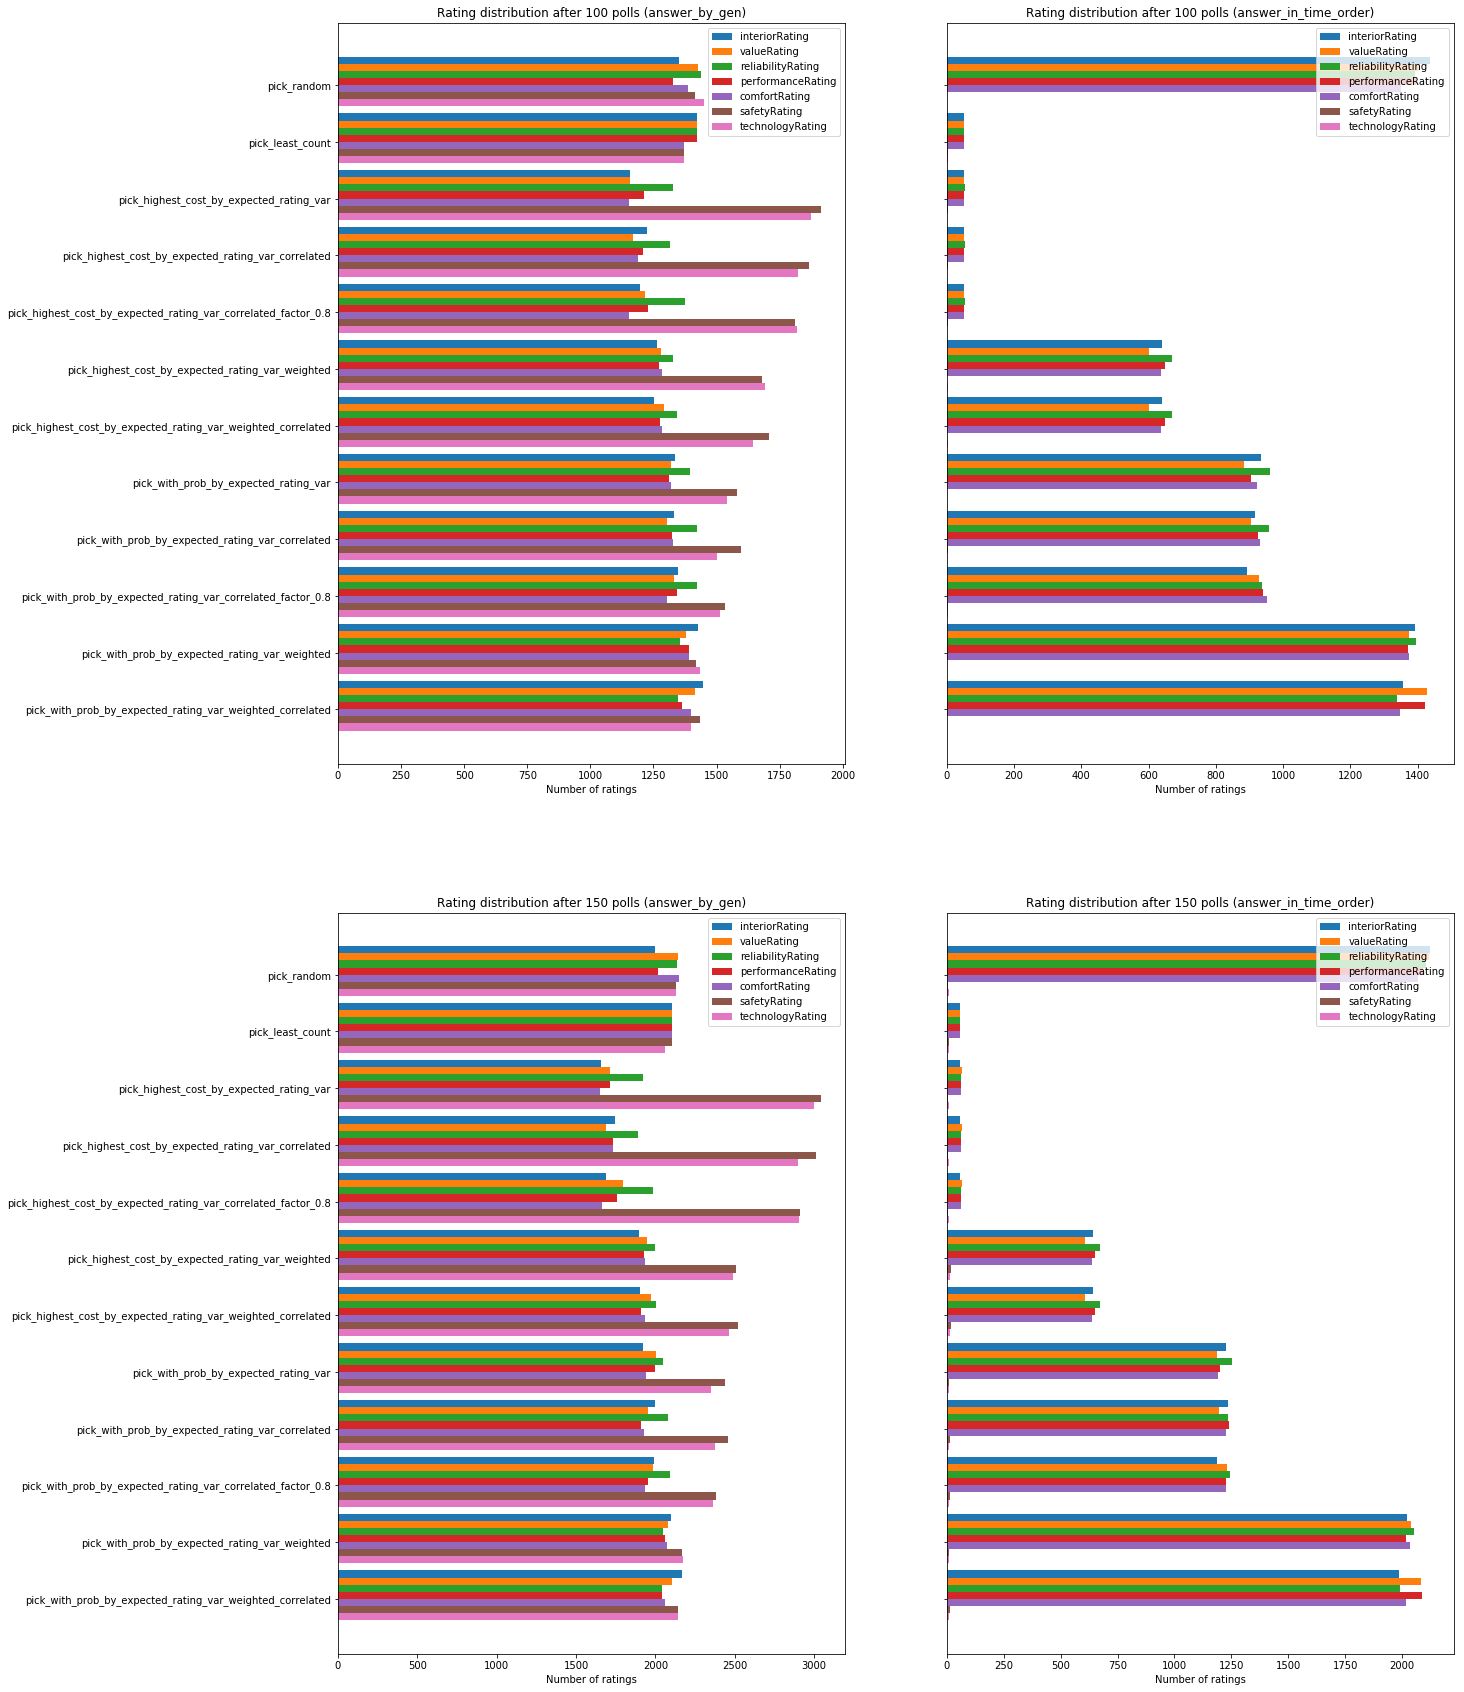

In [94]:
edmunds_pdf = PdfPages('plots/edmunds_p150.pdf')
#sim_result_paths = ['output/edmunds_l300_p300_q2.pickle', 'output/edmunds_l300_p300_q2_dup.pickle']
sim_result_paths = ['output/edmunds_l300_p300_q2.pickle']
path_to_goal_stats = OrderedDict()
for sim_result_path in sim_result_paths:    
    with open(sim_result_path, 'rb') as f:
        product_to_config_stats = pickle.load(f)

    goal_to_stats_average = soli_start.summary_product_to_config_stats(
        product_to_config_stats)
    path_to_goal_stats[sim_result_path] = goal_to_stats_average

for path, goal_to_stats_average in path_to_goal_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    fig = plot_pick_answer_goals(goal_to_stats_average, poll_max=150, fig_h=60)
    edmunds_pdf.savefig(fig)
    
    print('------------------------Rating distribution------------------------\n')
    fig = plot_ratings(goal_to_stats_average, polls=[100, 150], fig_h=30)
    edmunds_pdf.savefig(fig)
edmunds_pdf.close()

------------------------output/bliu_l100_p100_q2_2.pickle------------------------



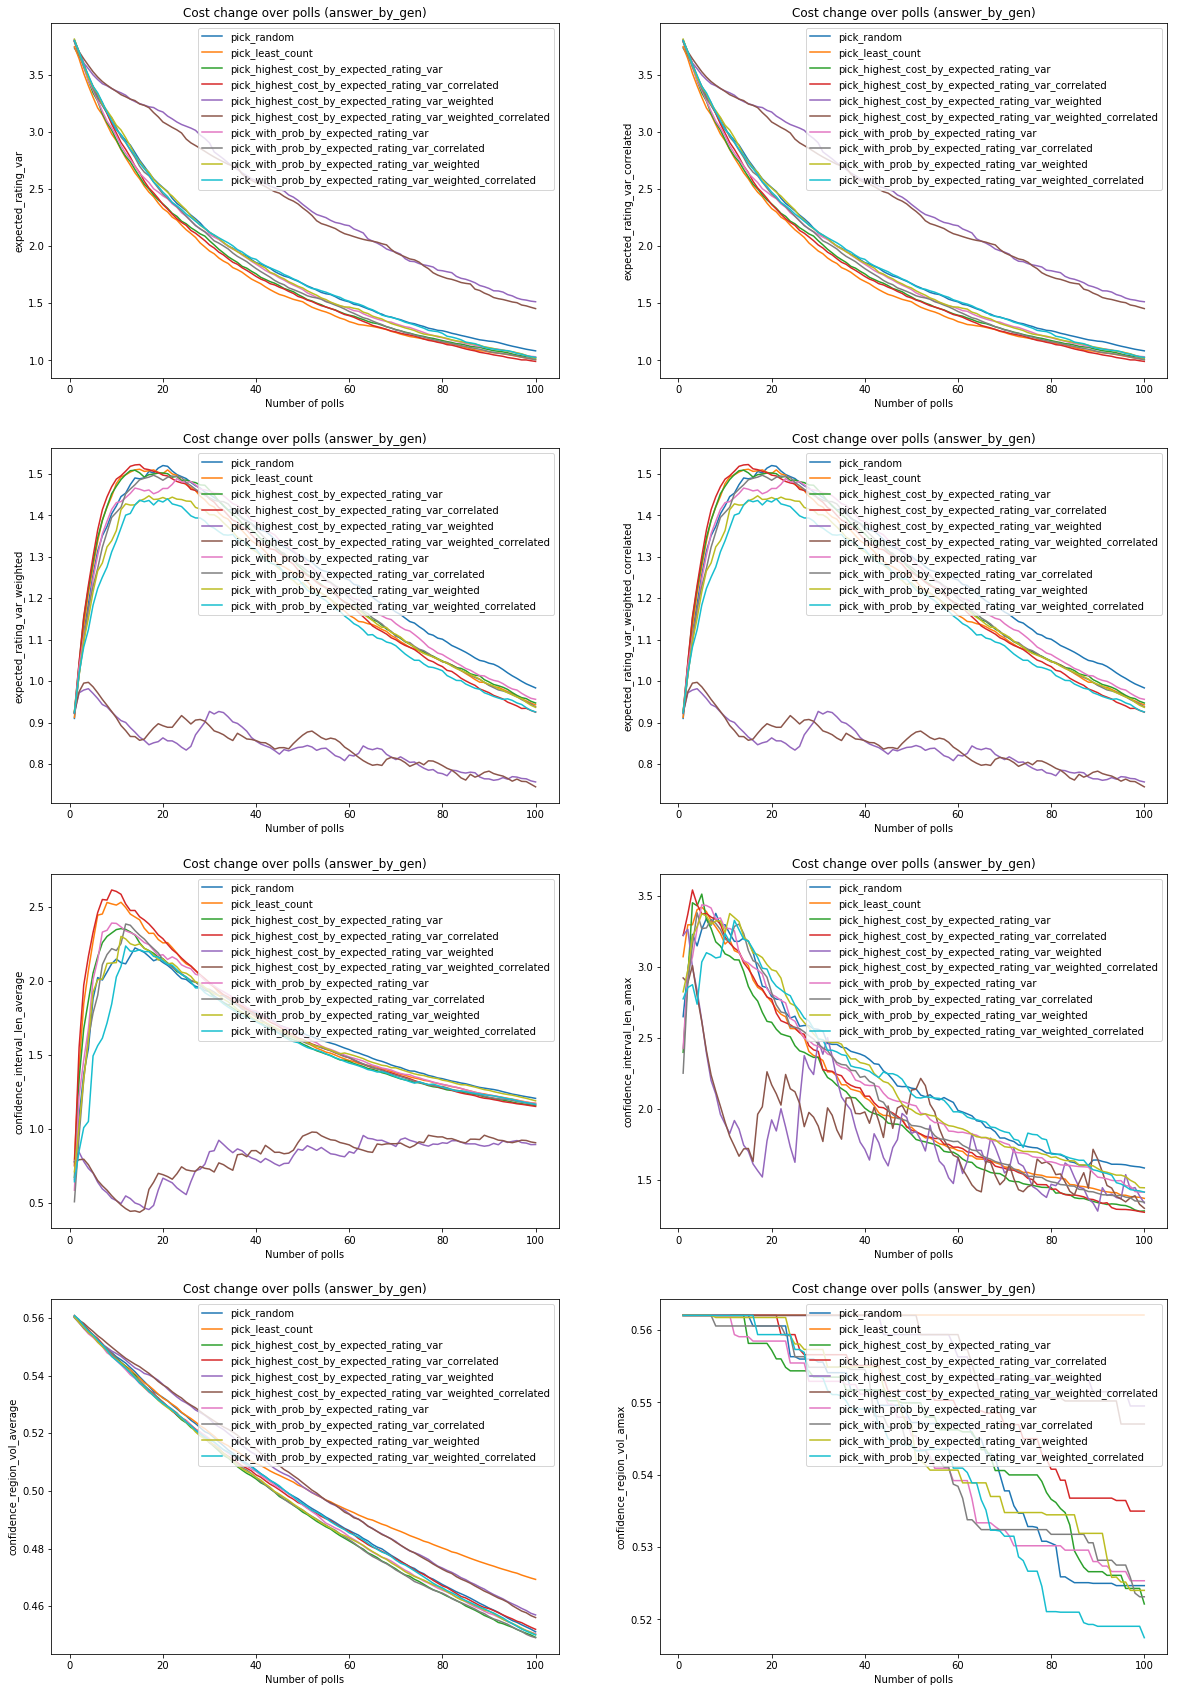

------------------------output/bliu_l100_p100_q2_2.pickle------------------------



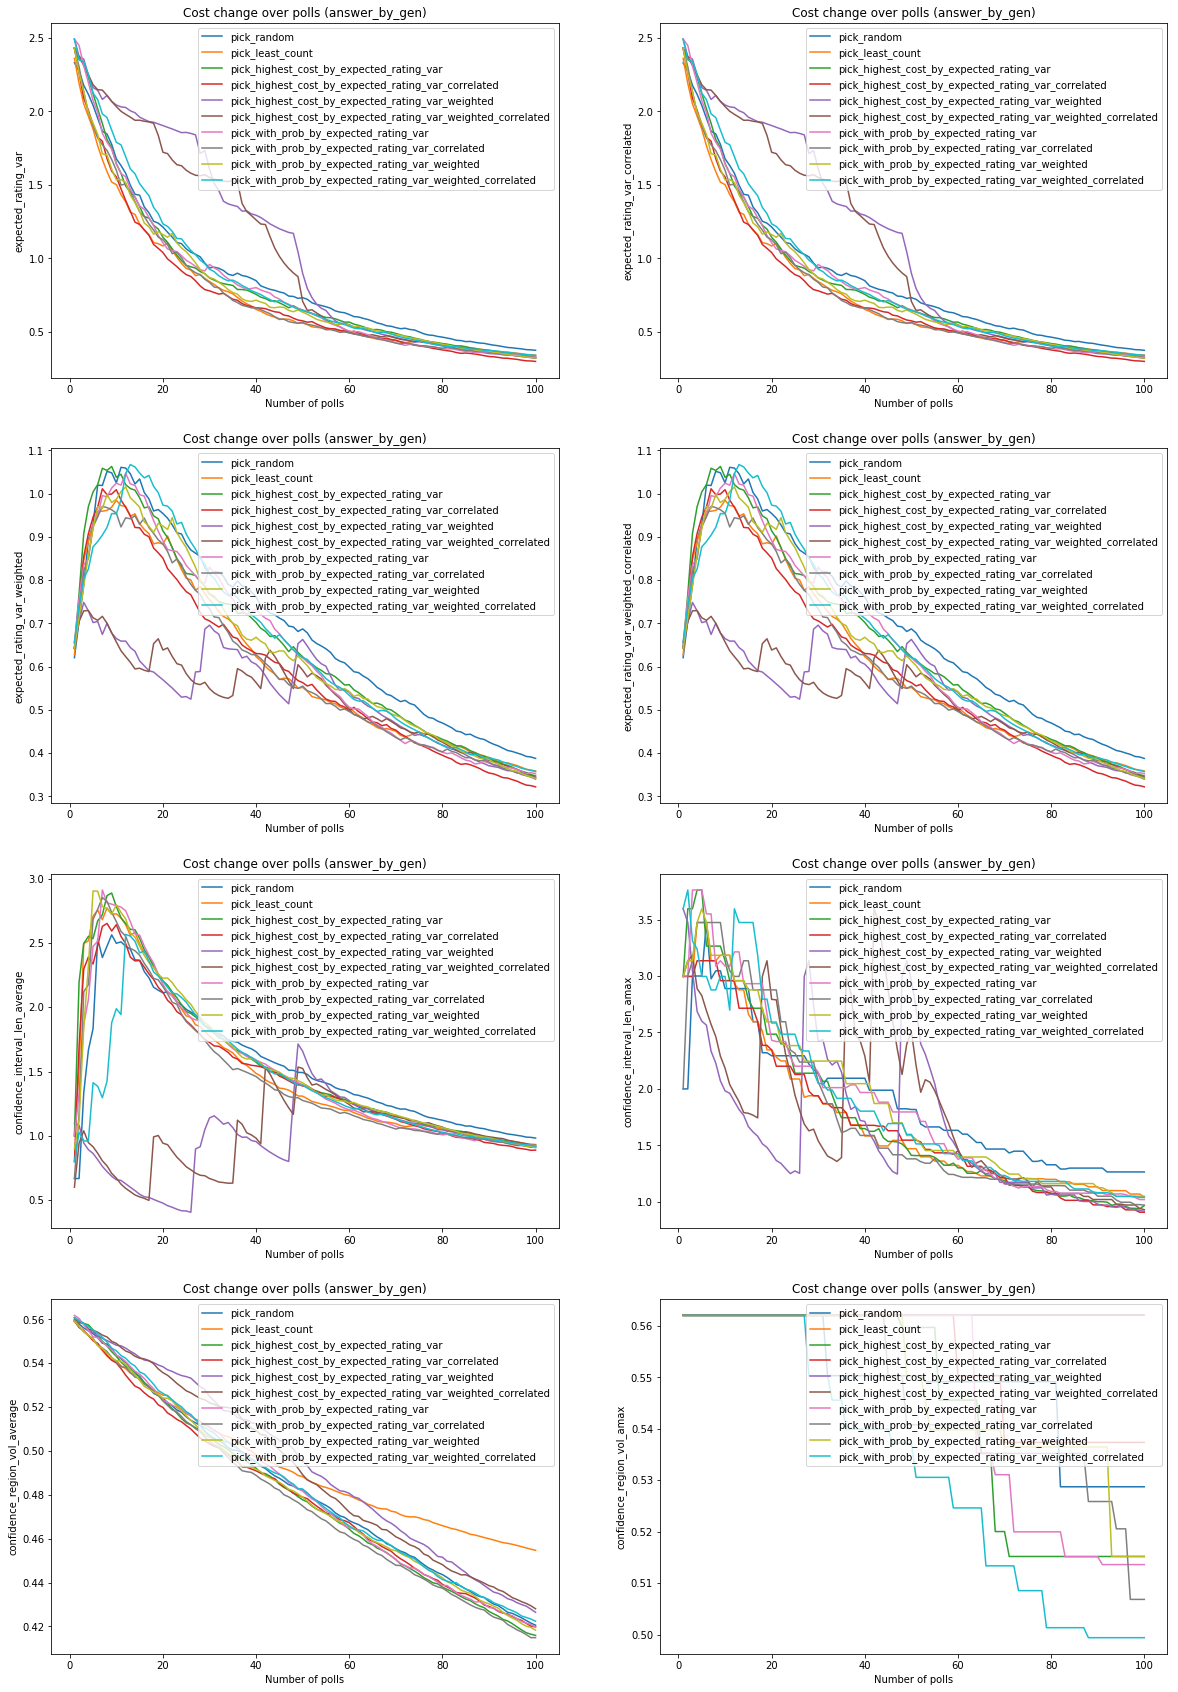

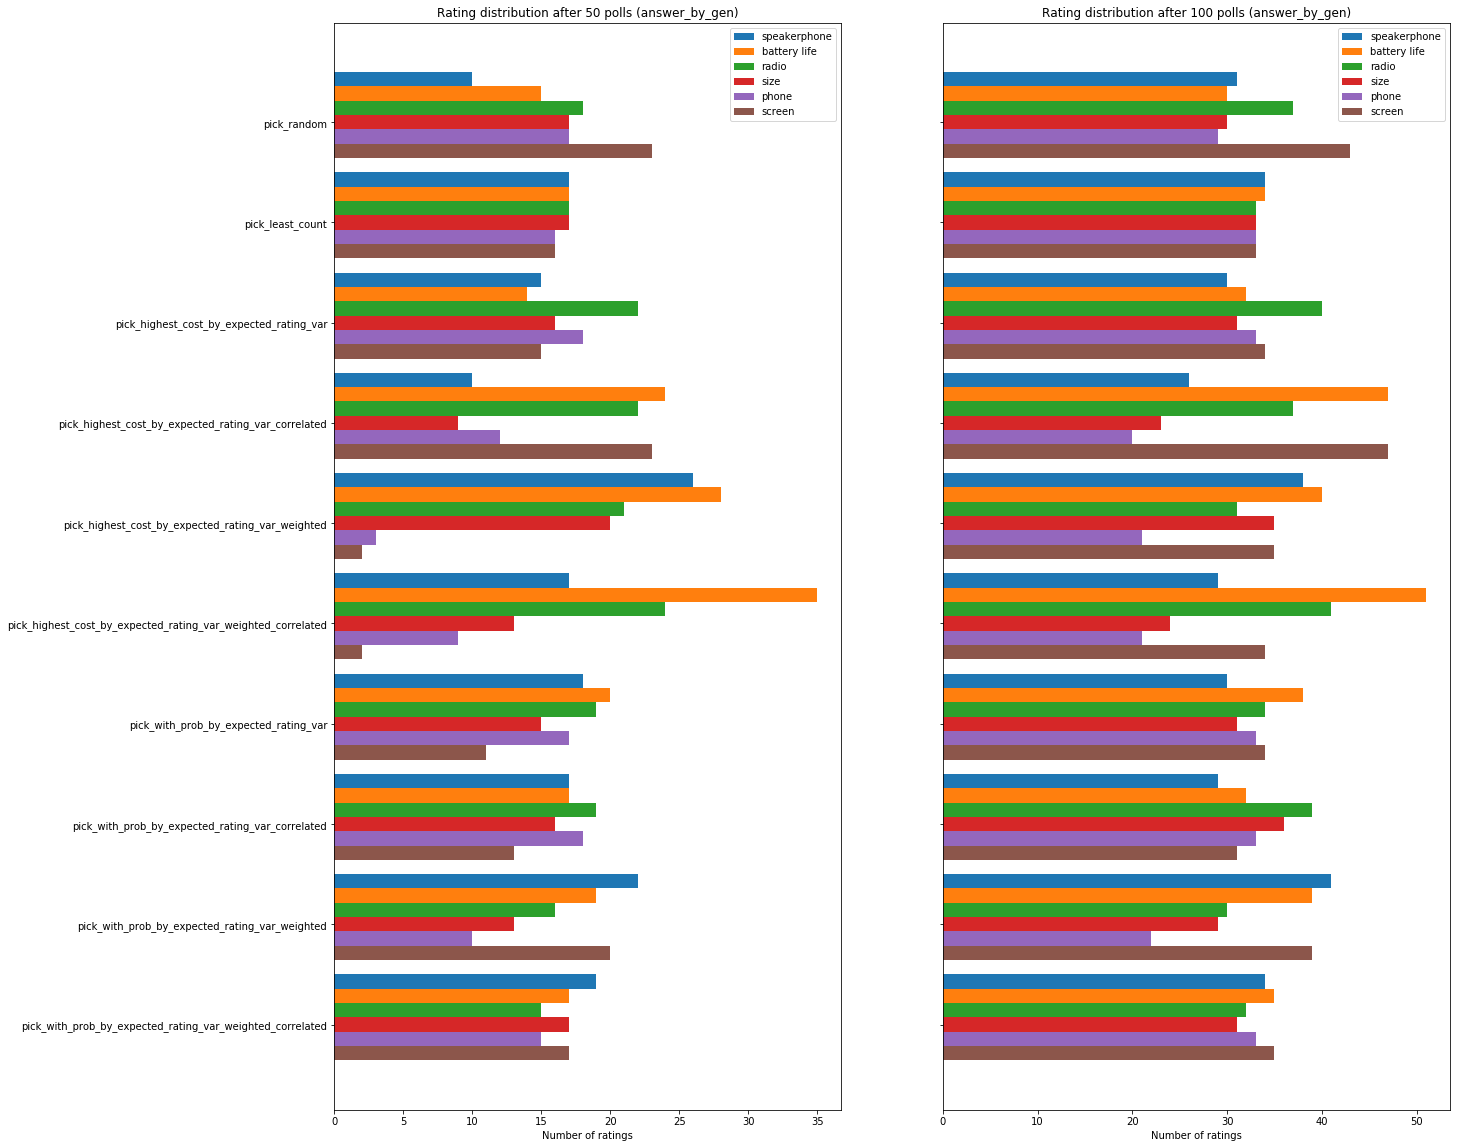

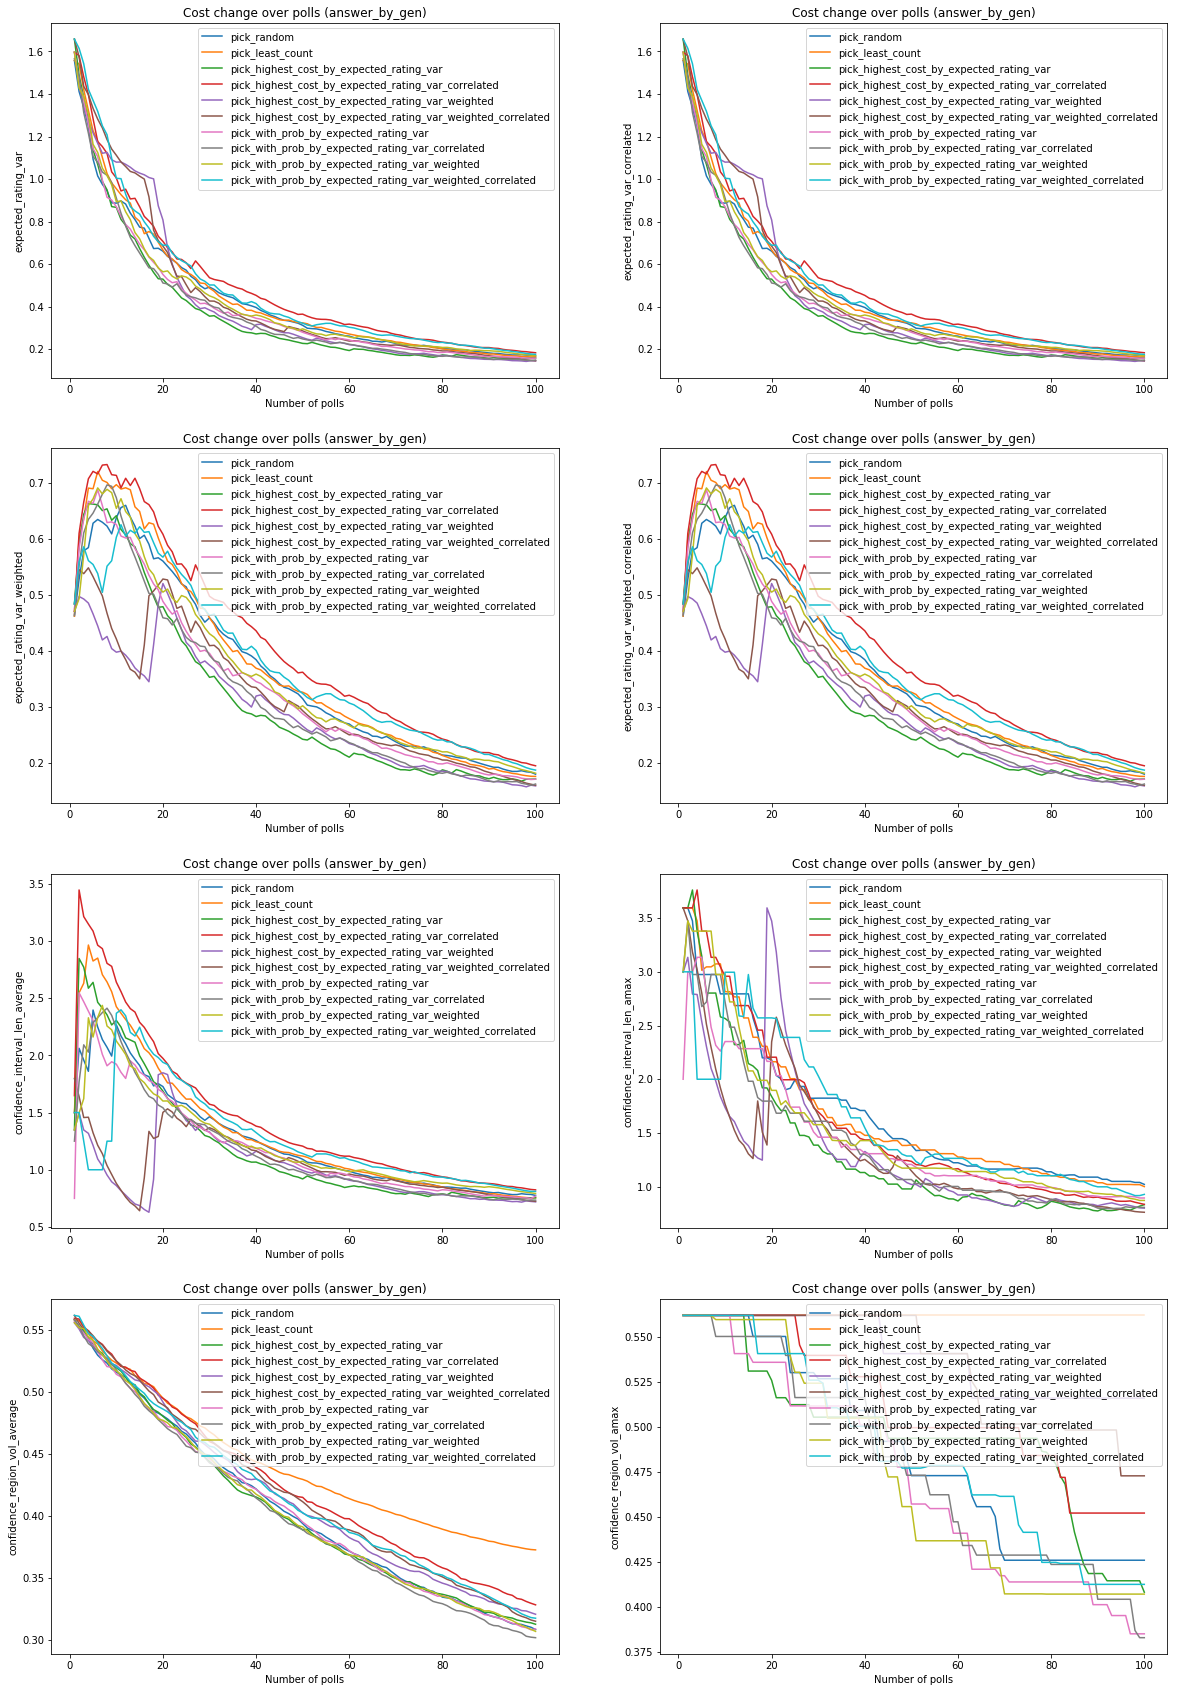

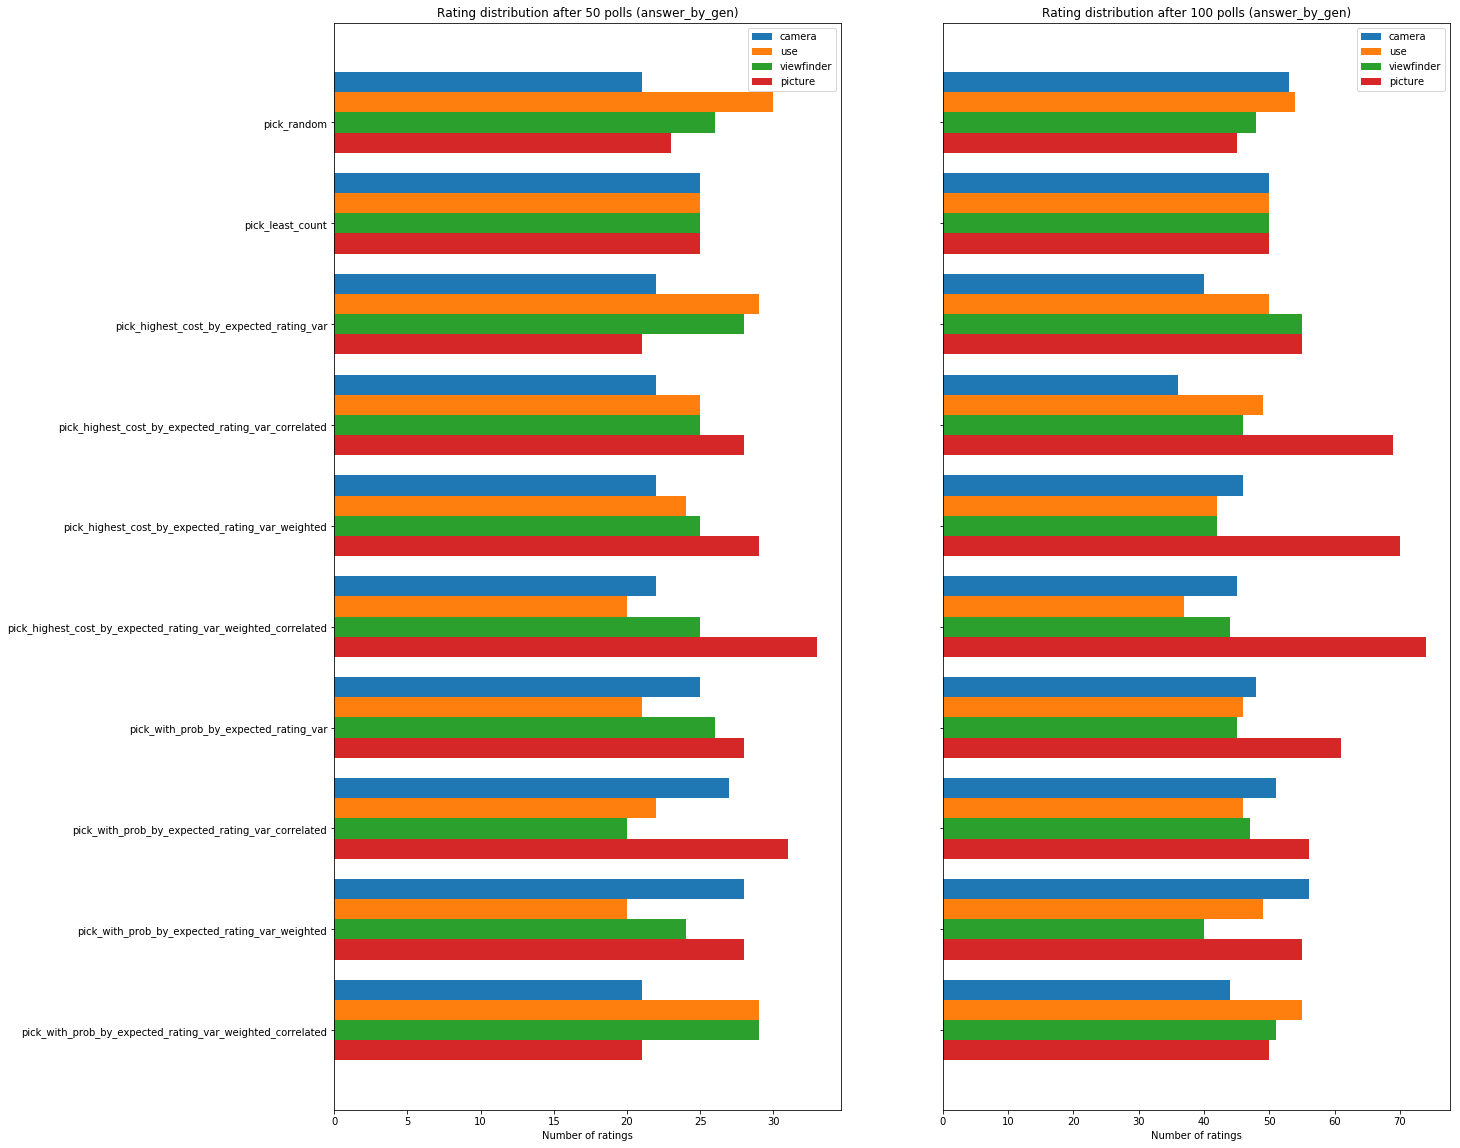

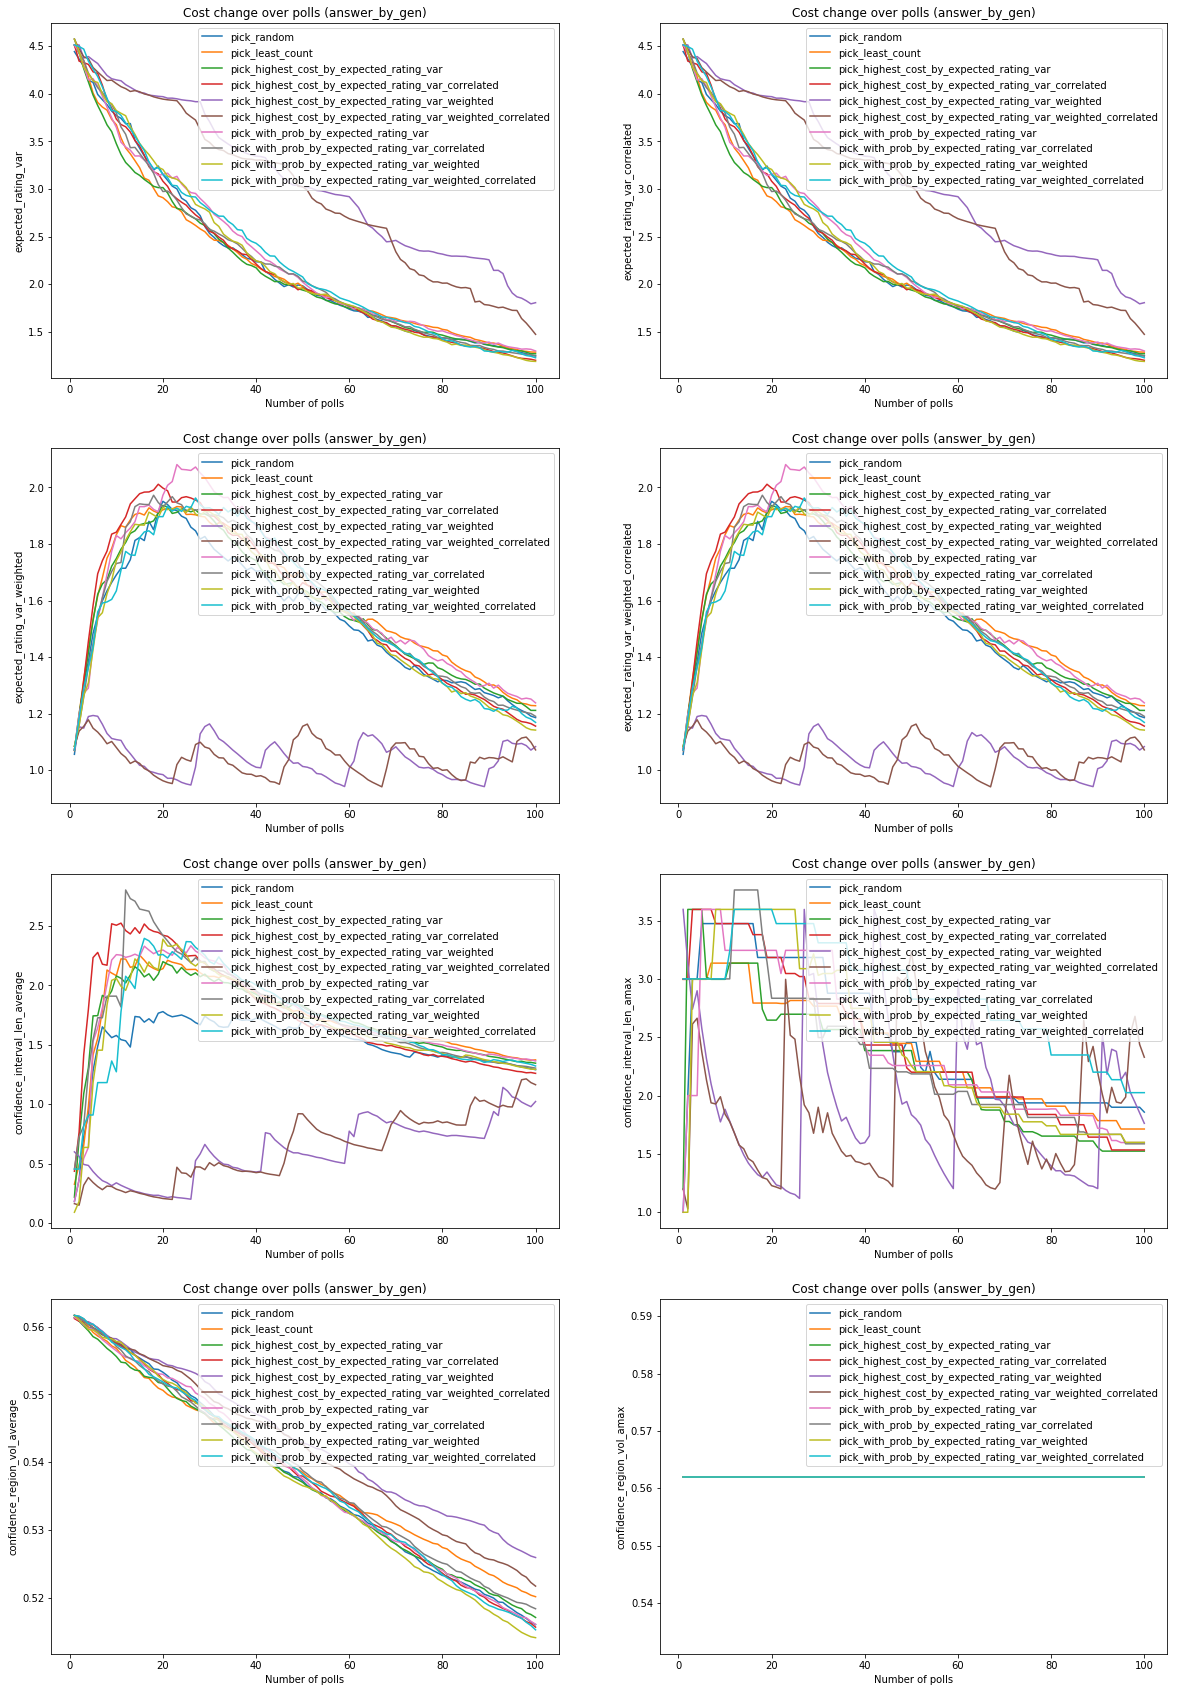

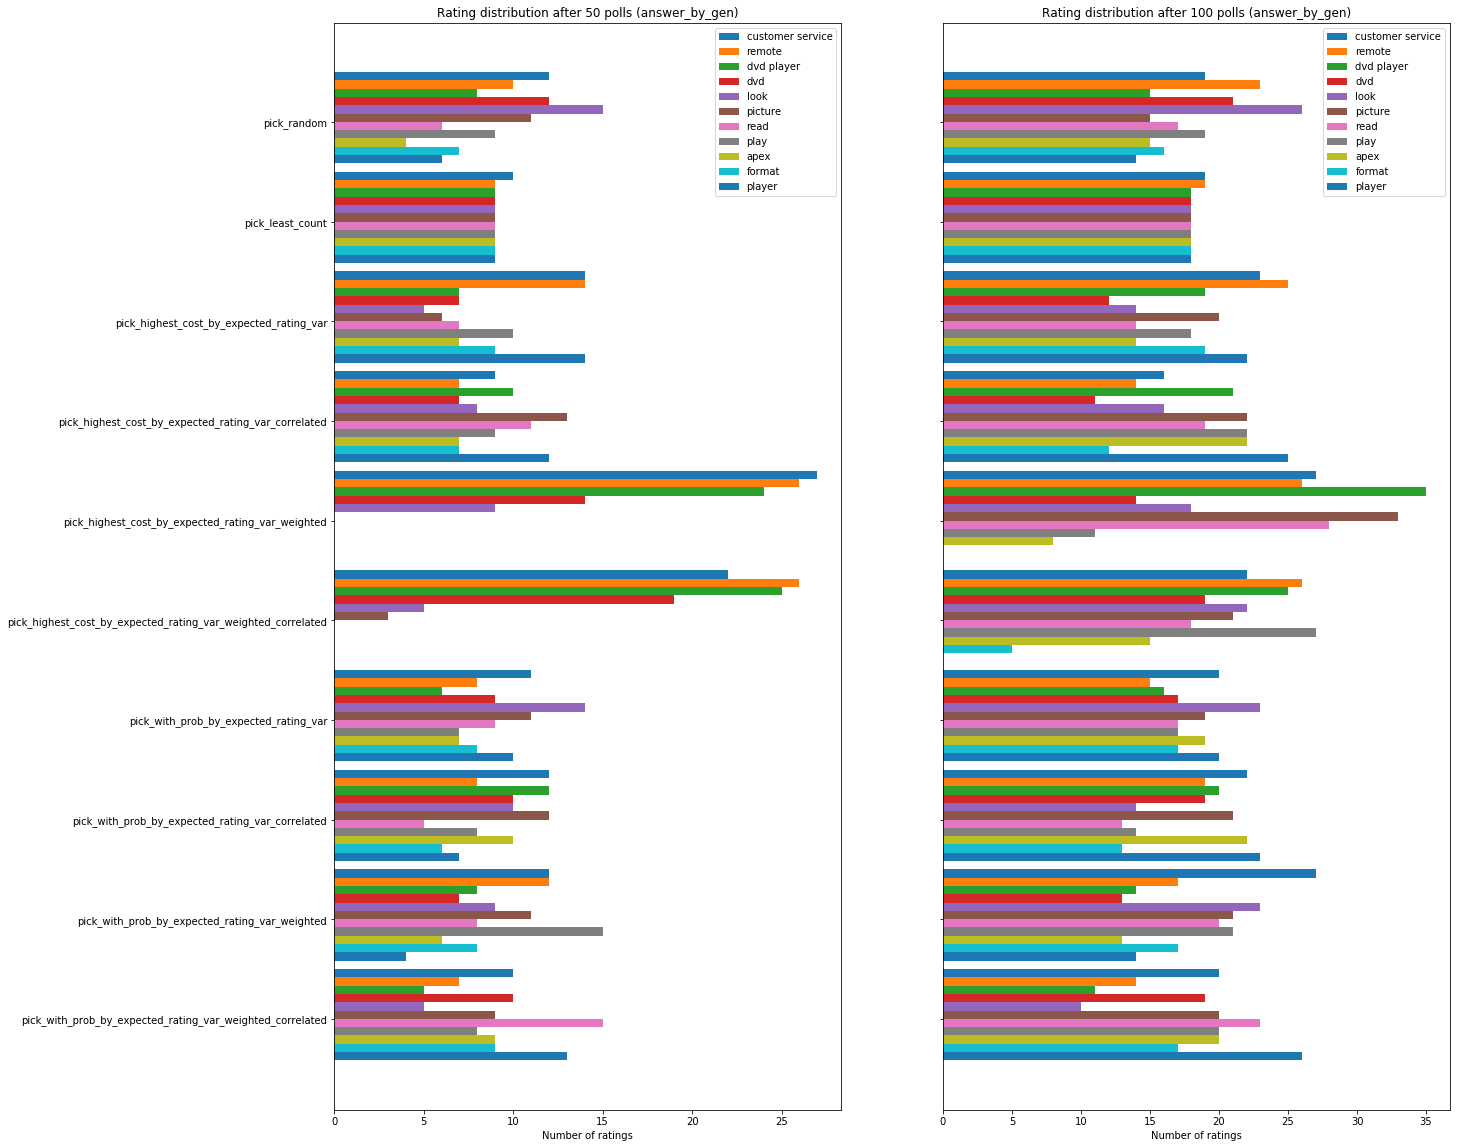

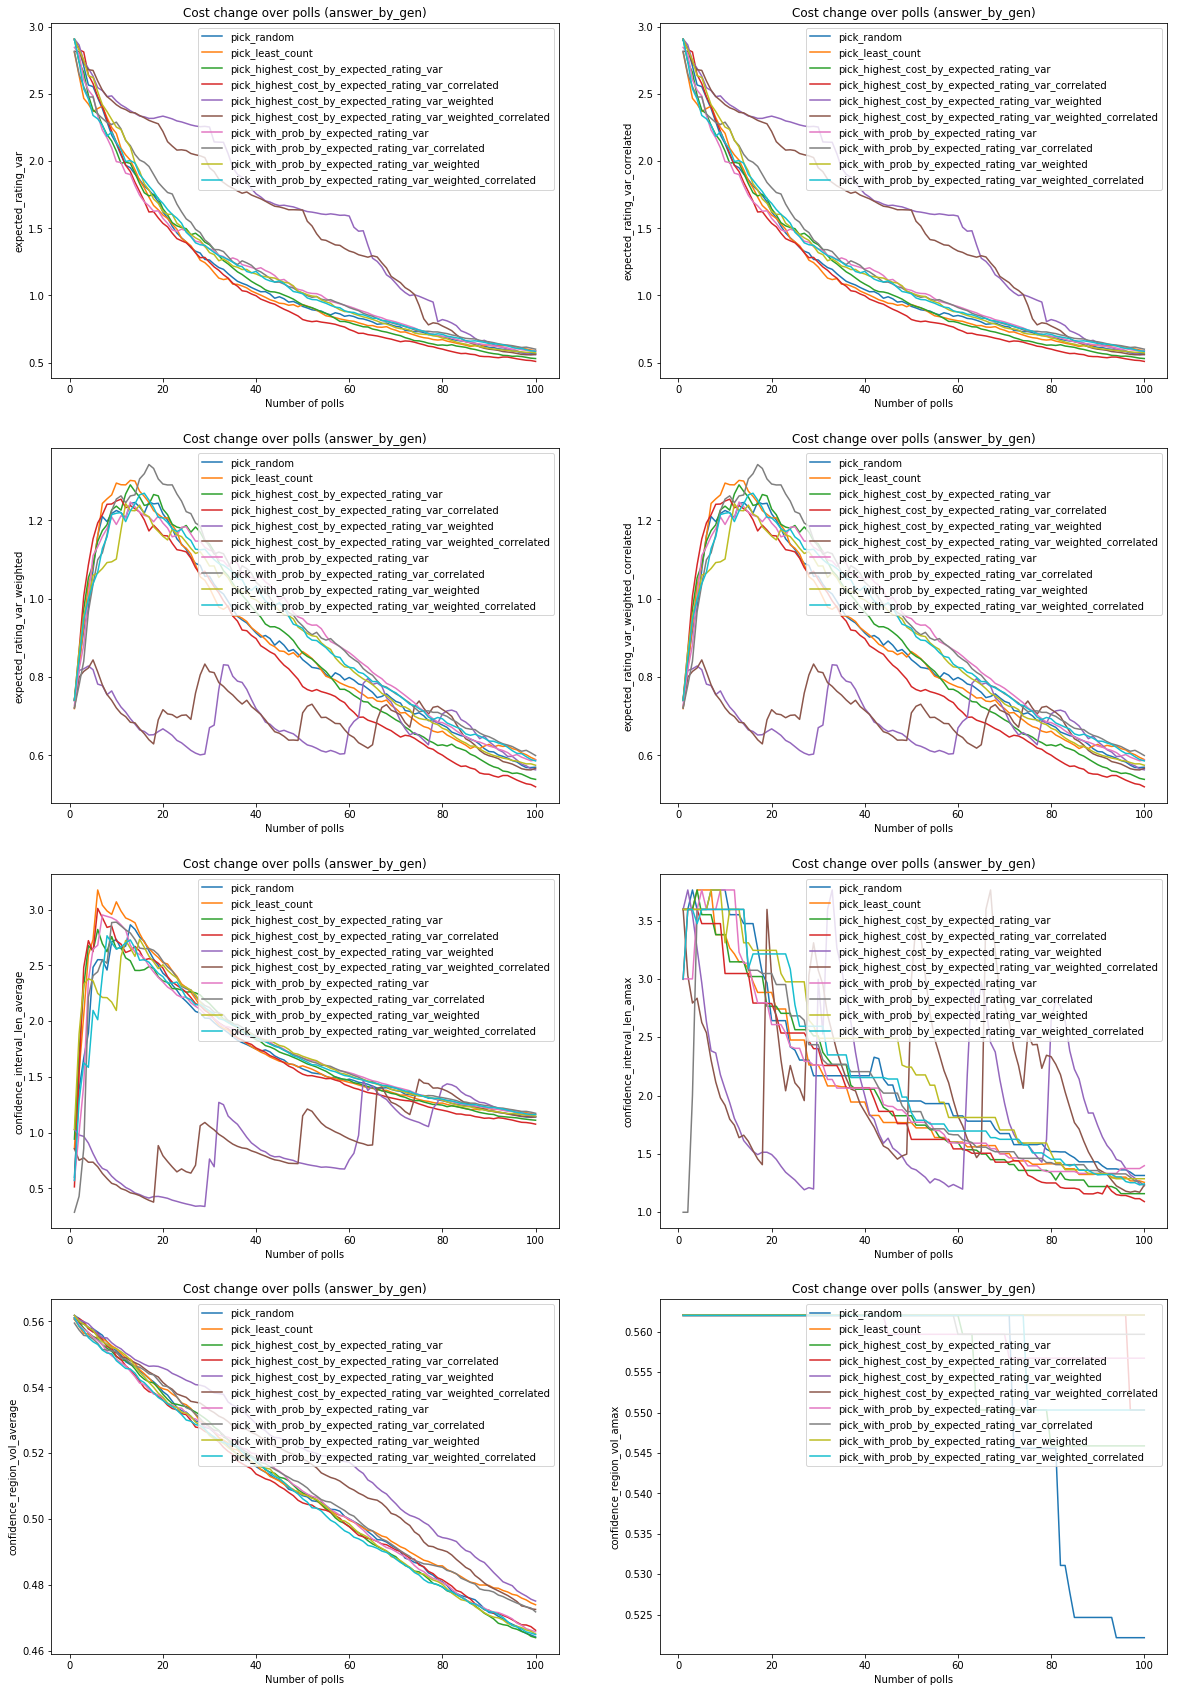

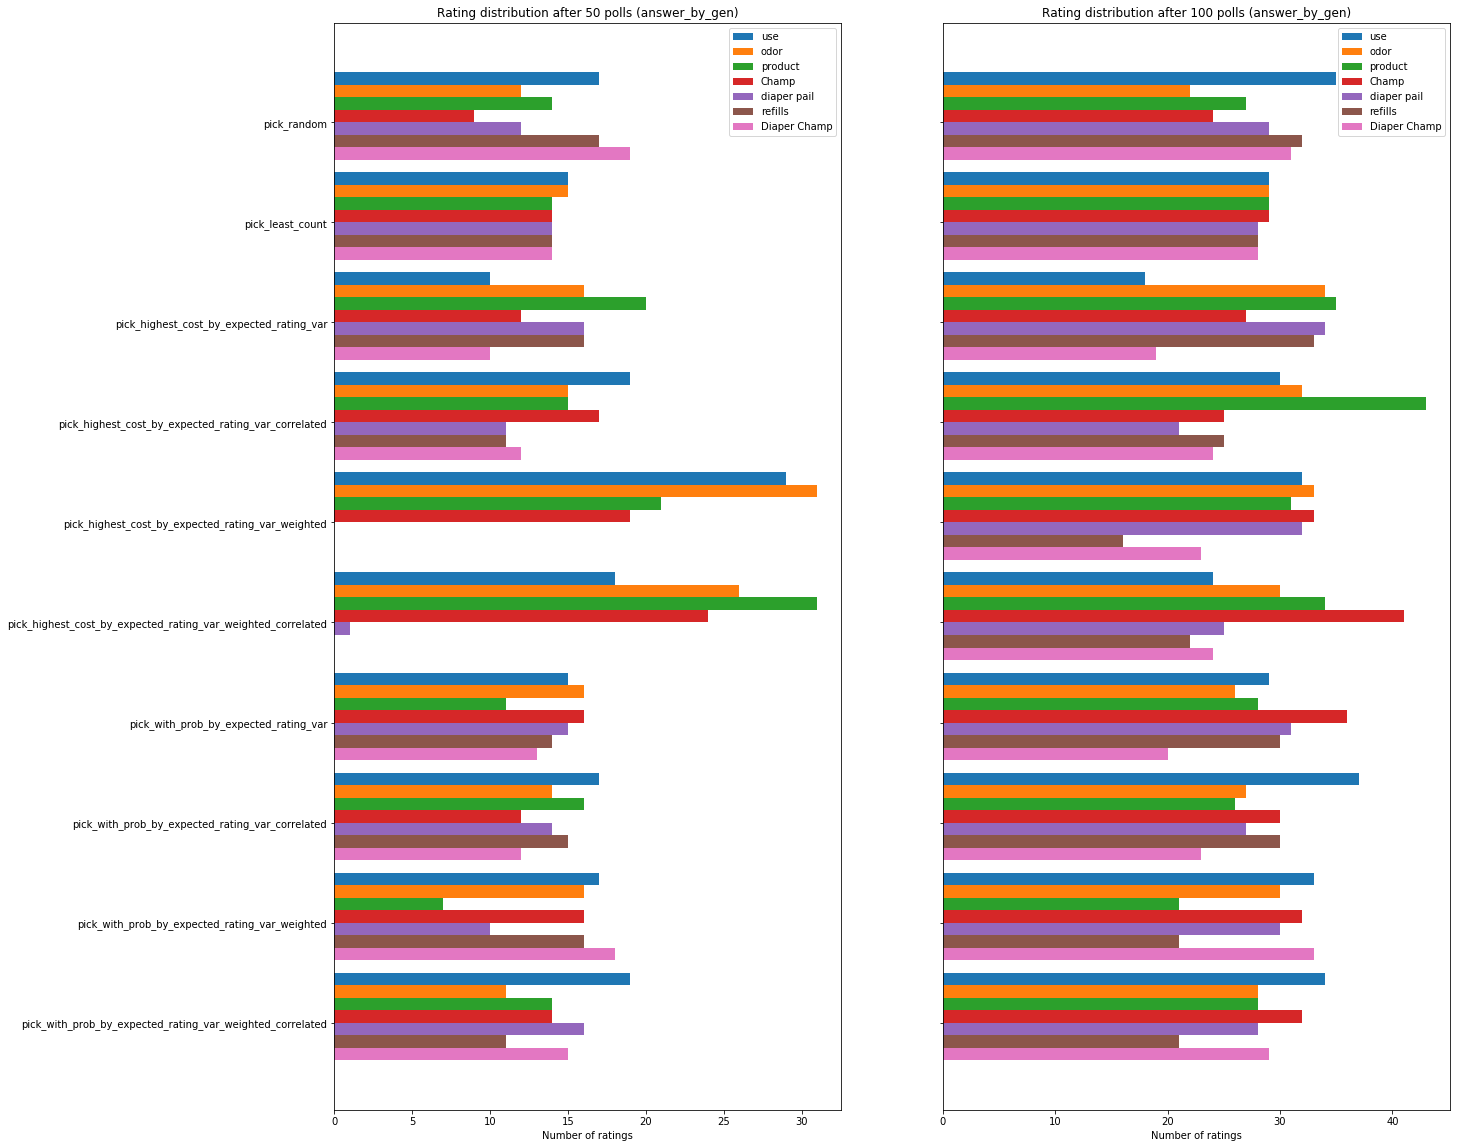

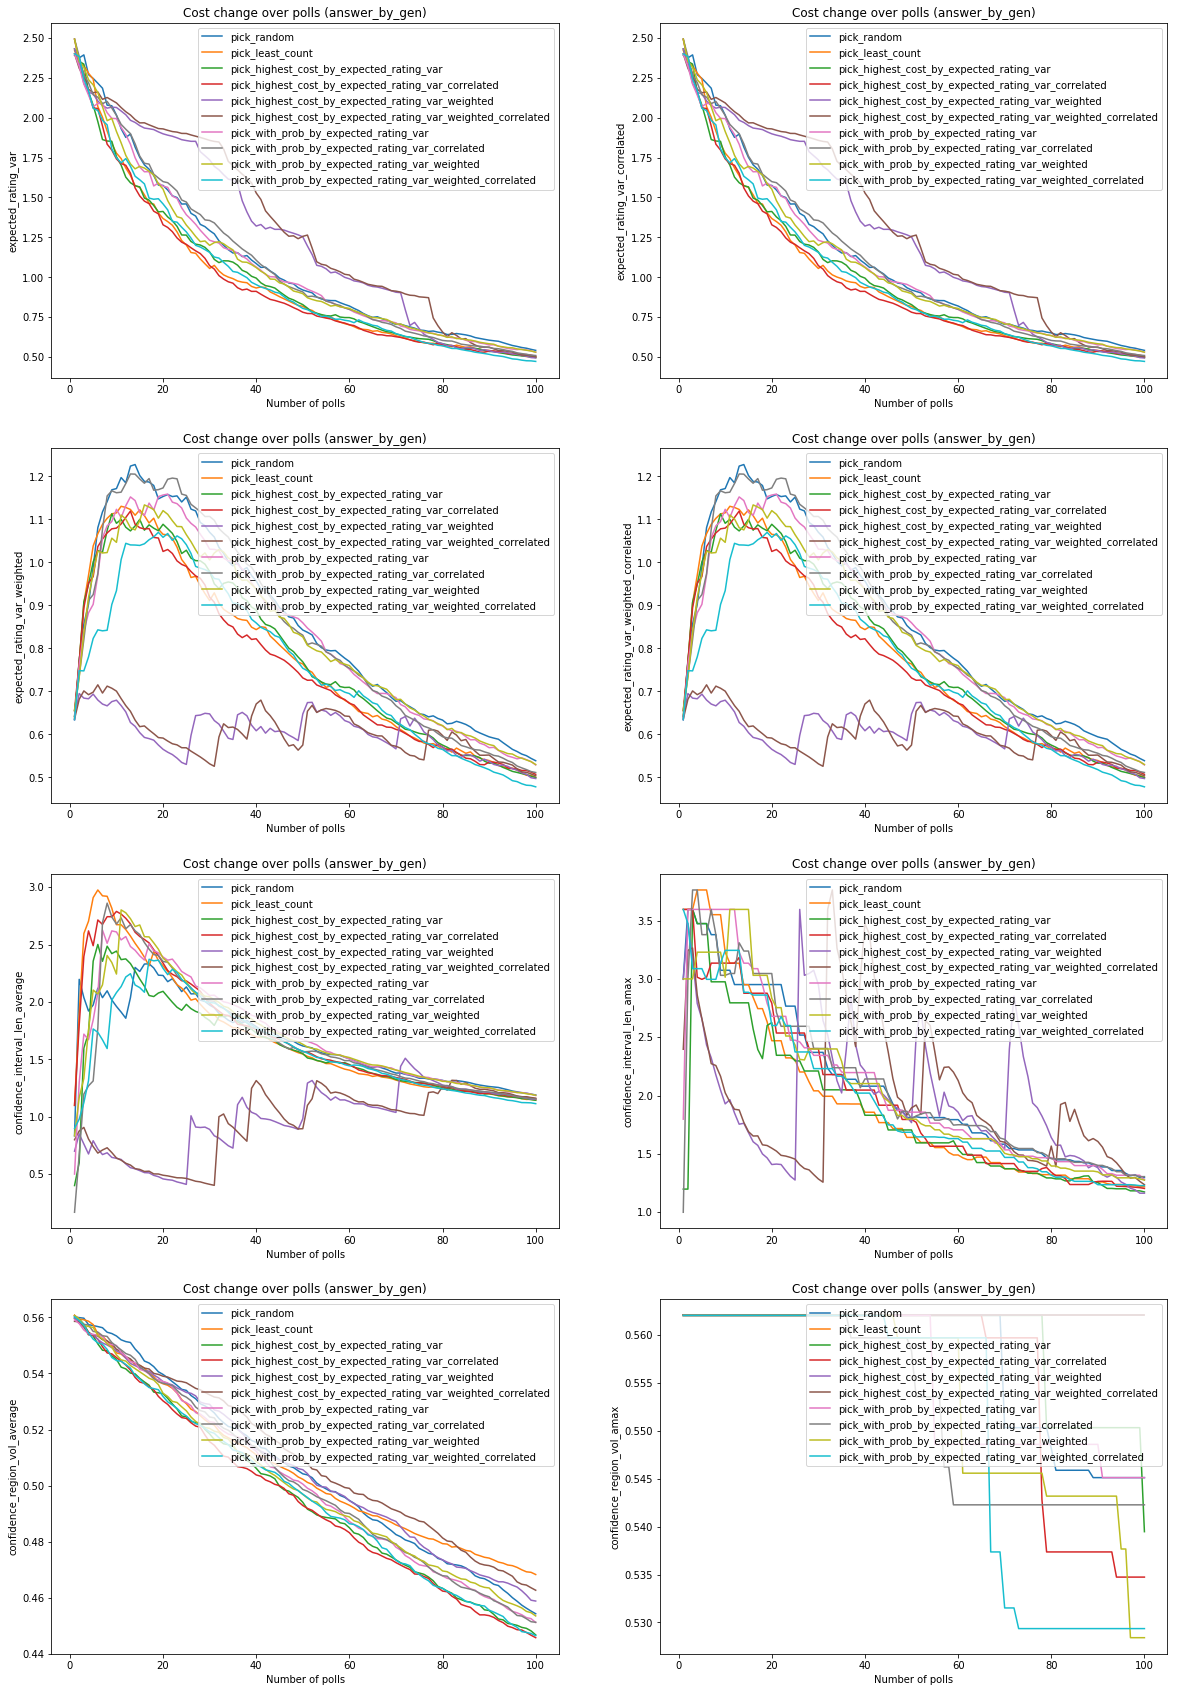

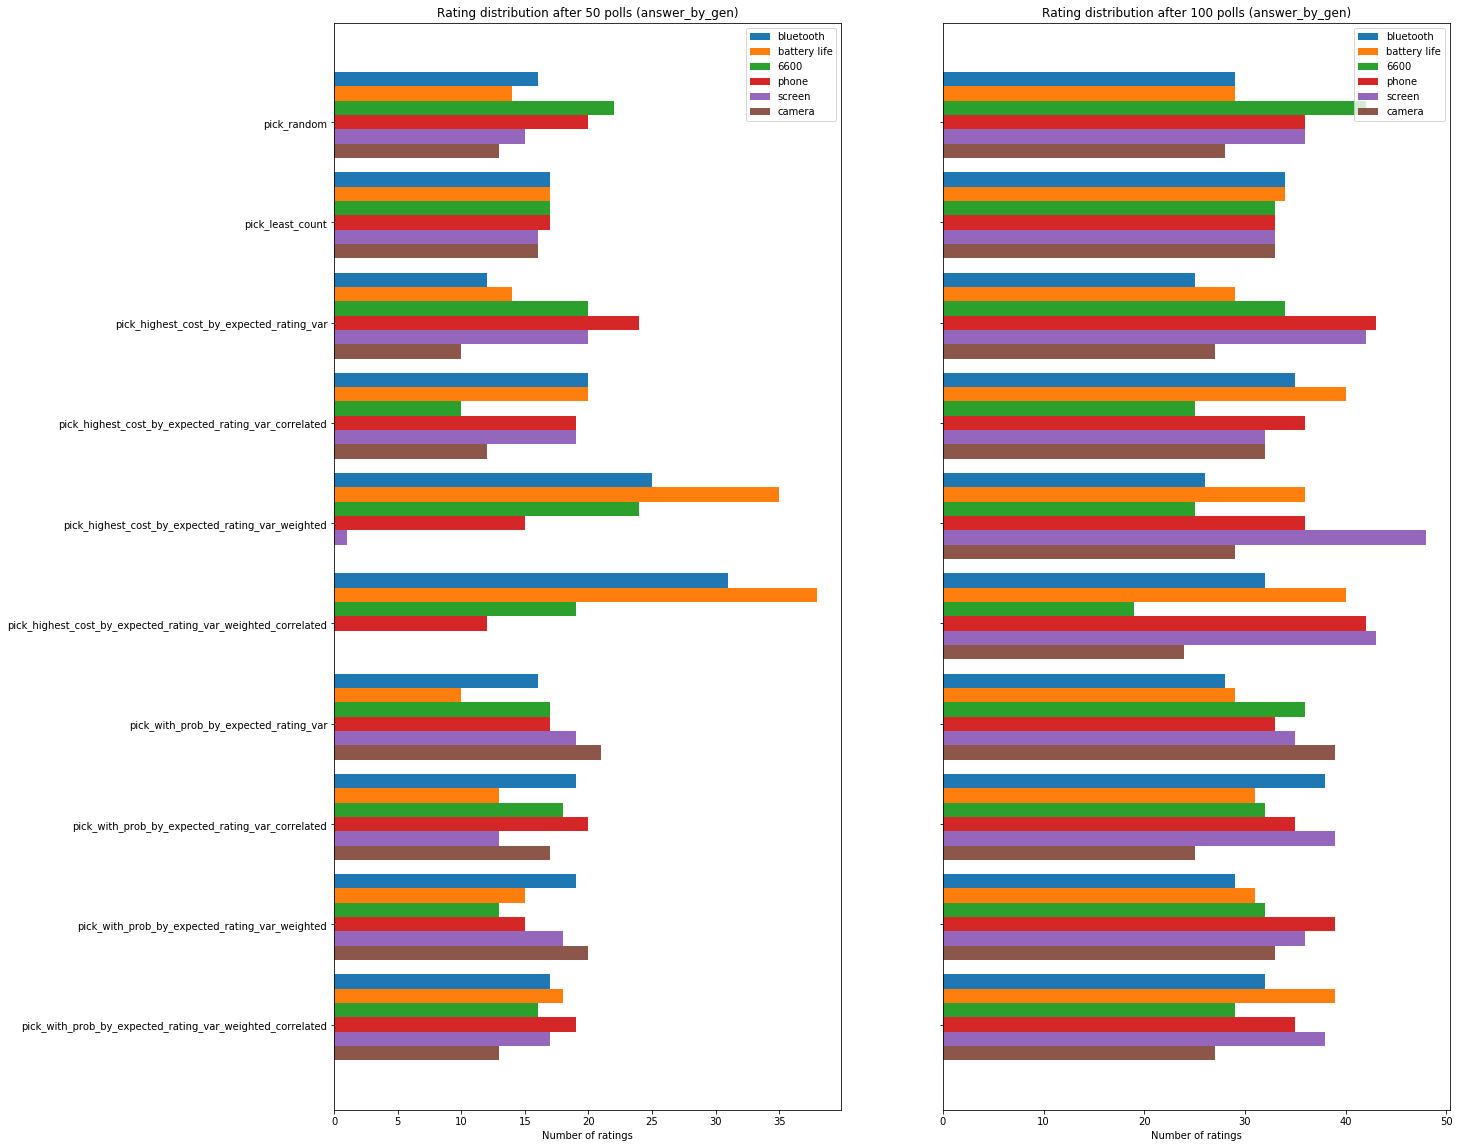

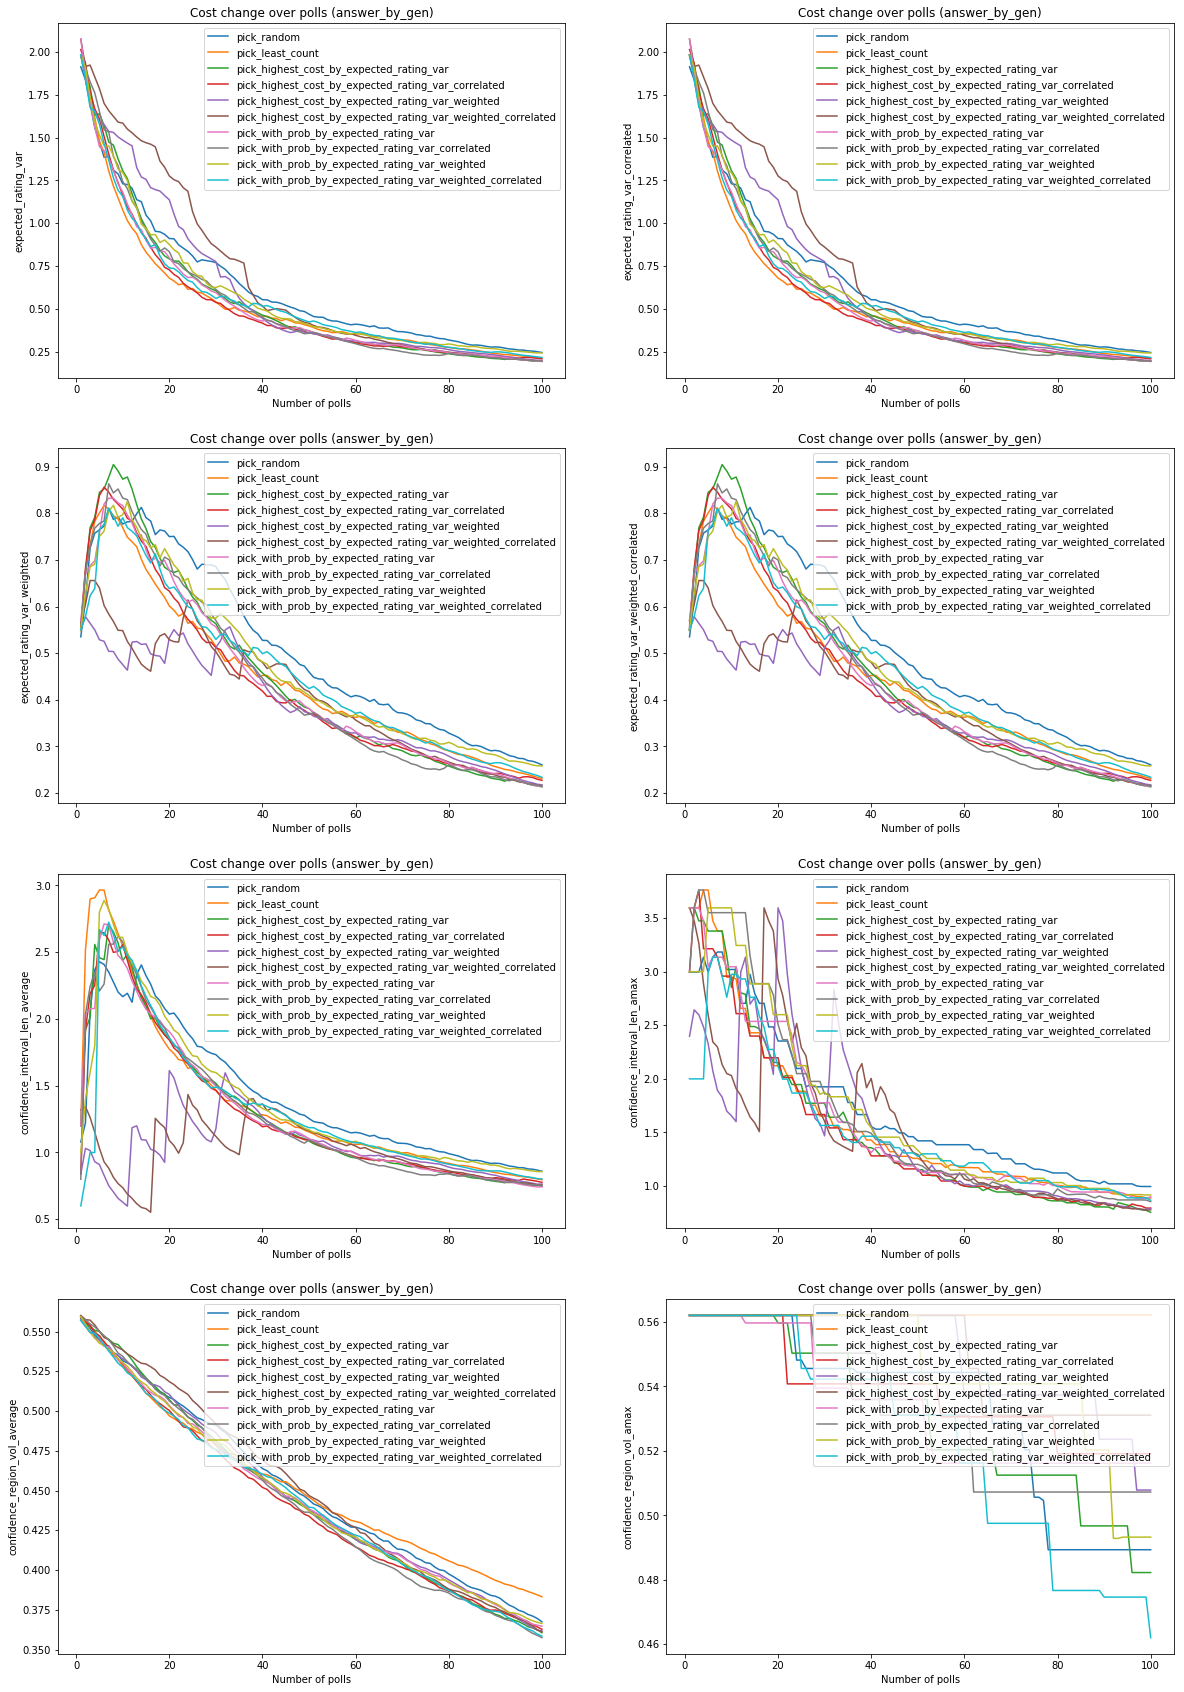

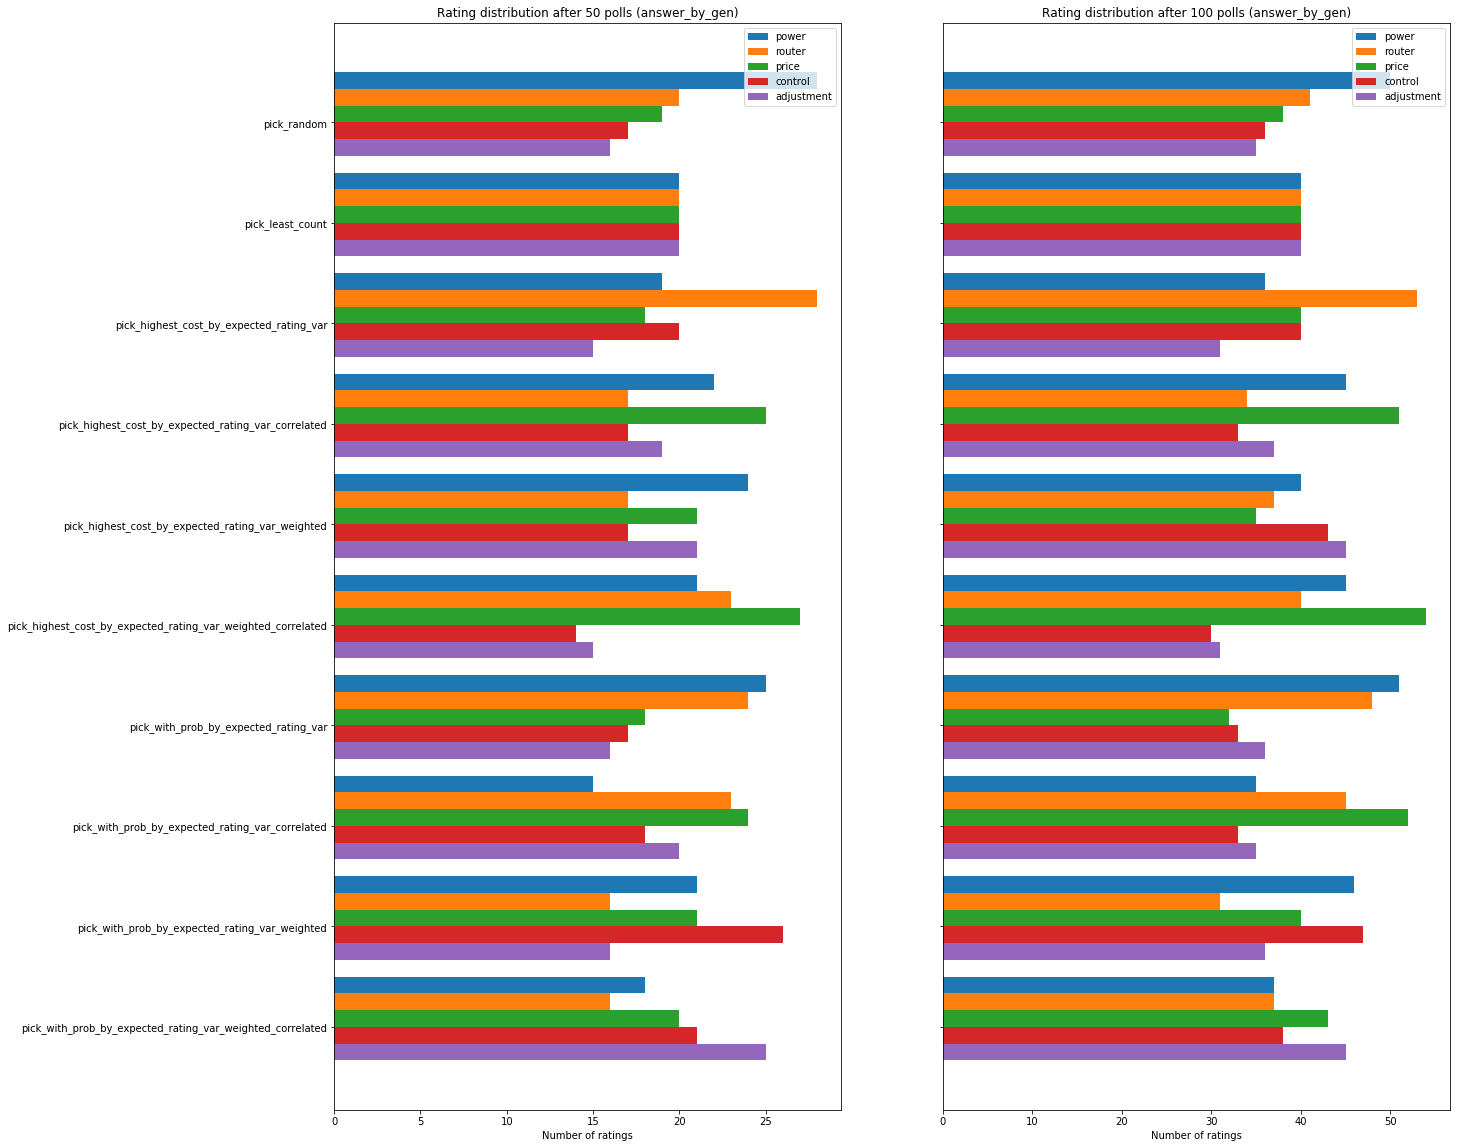

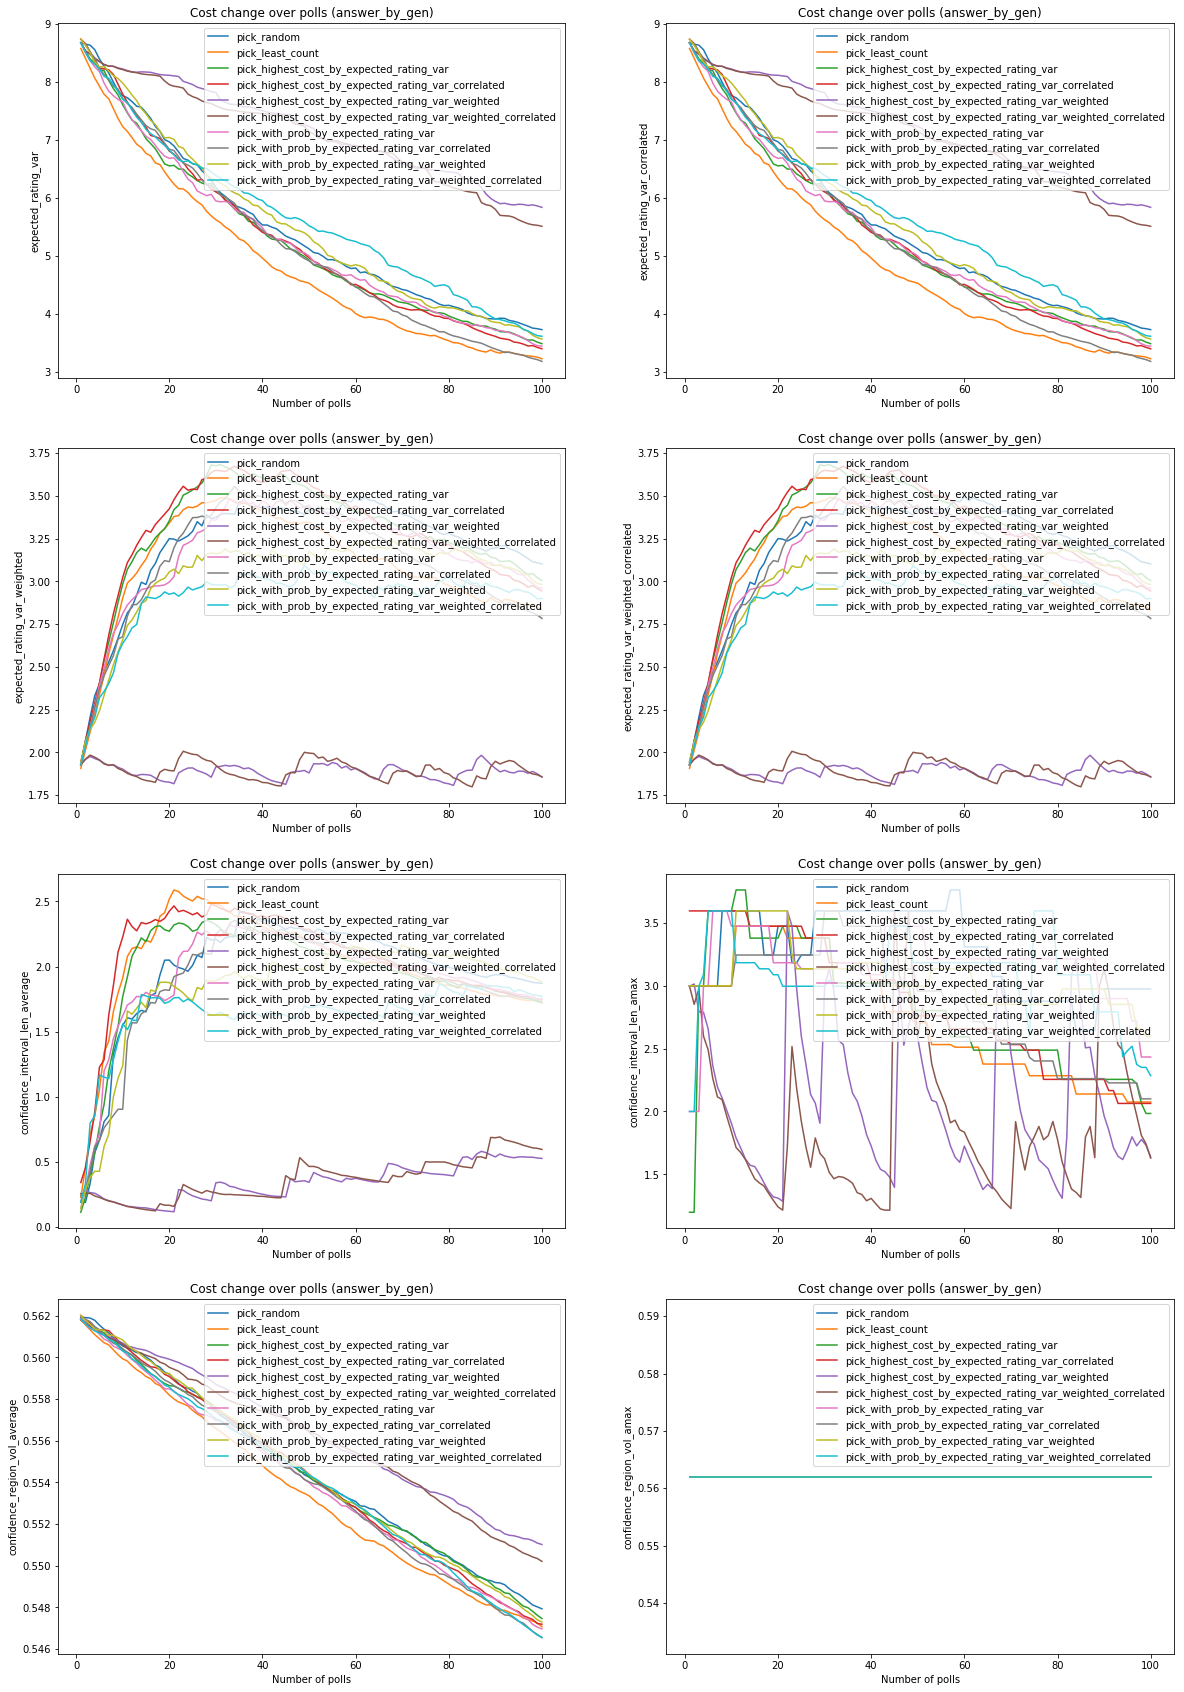

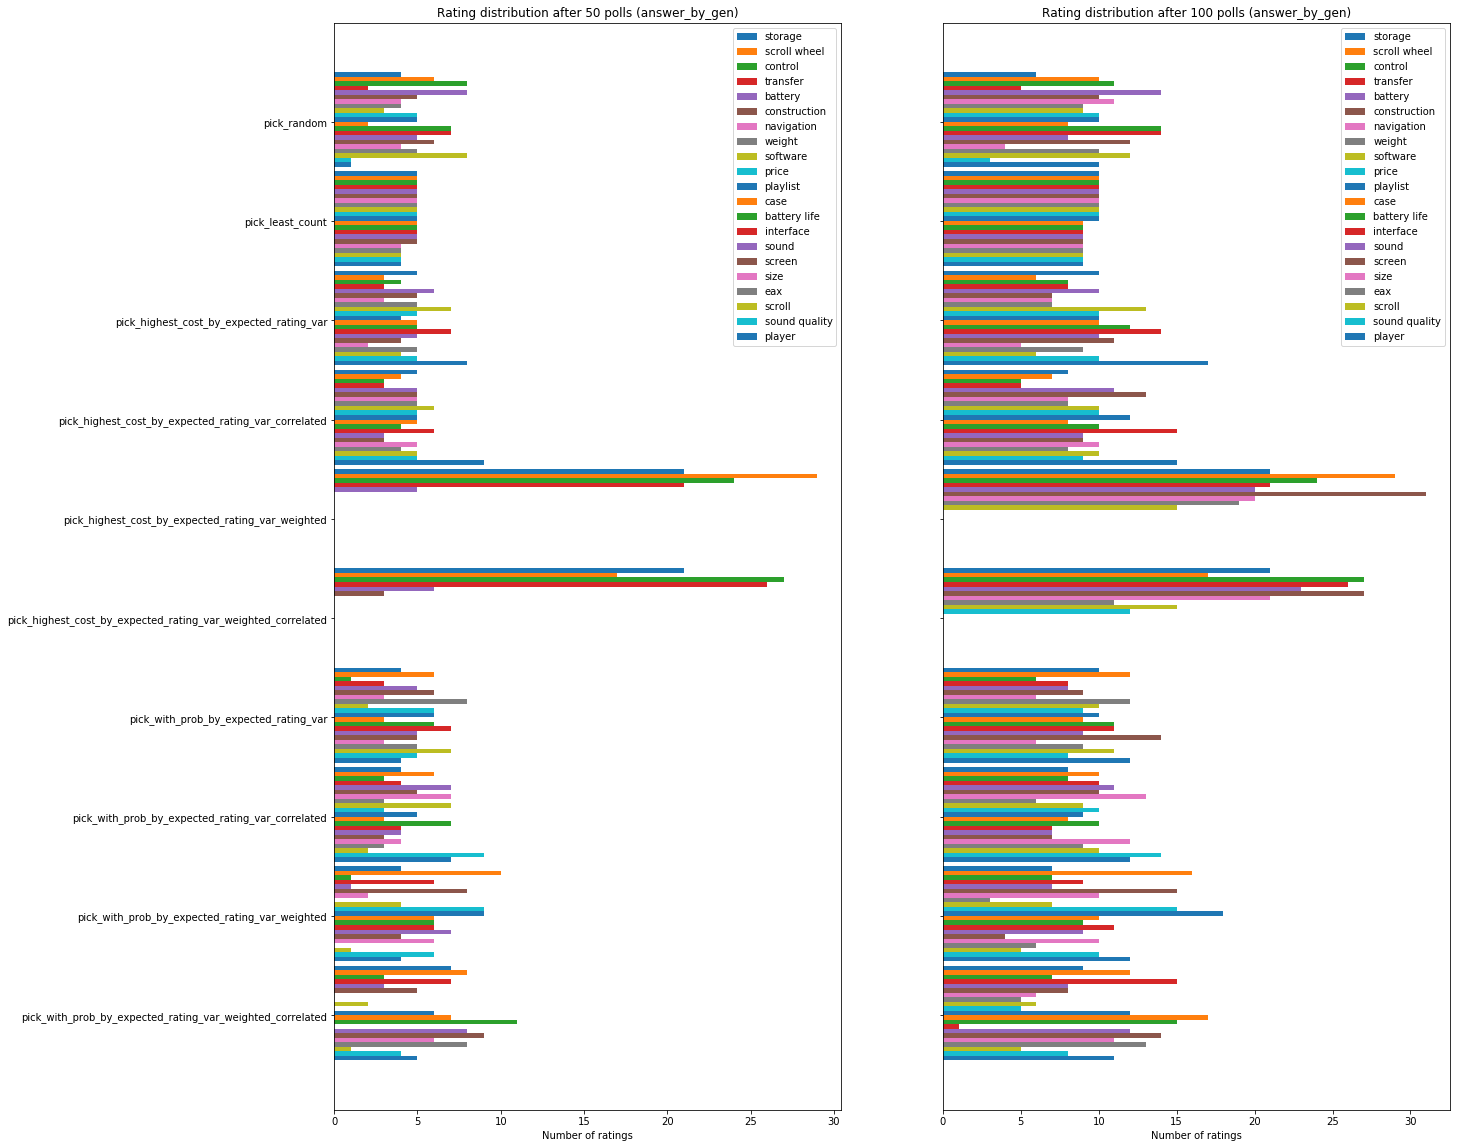

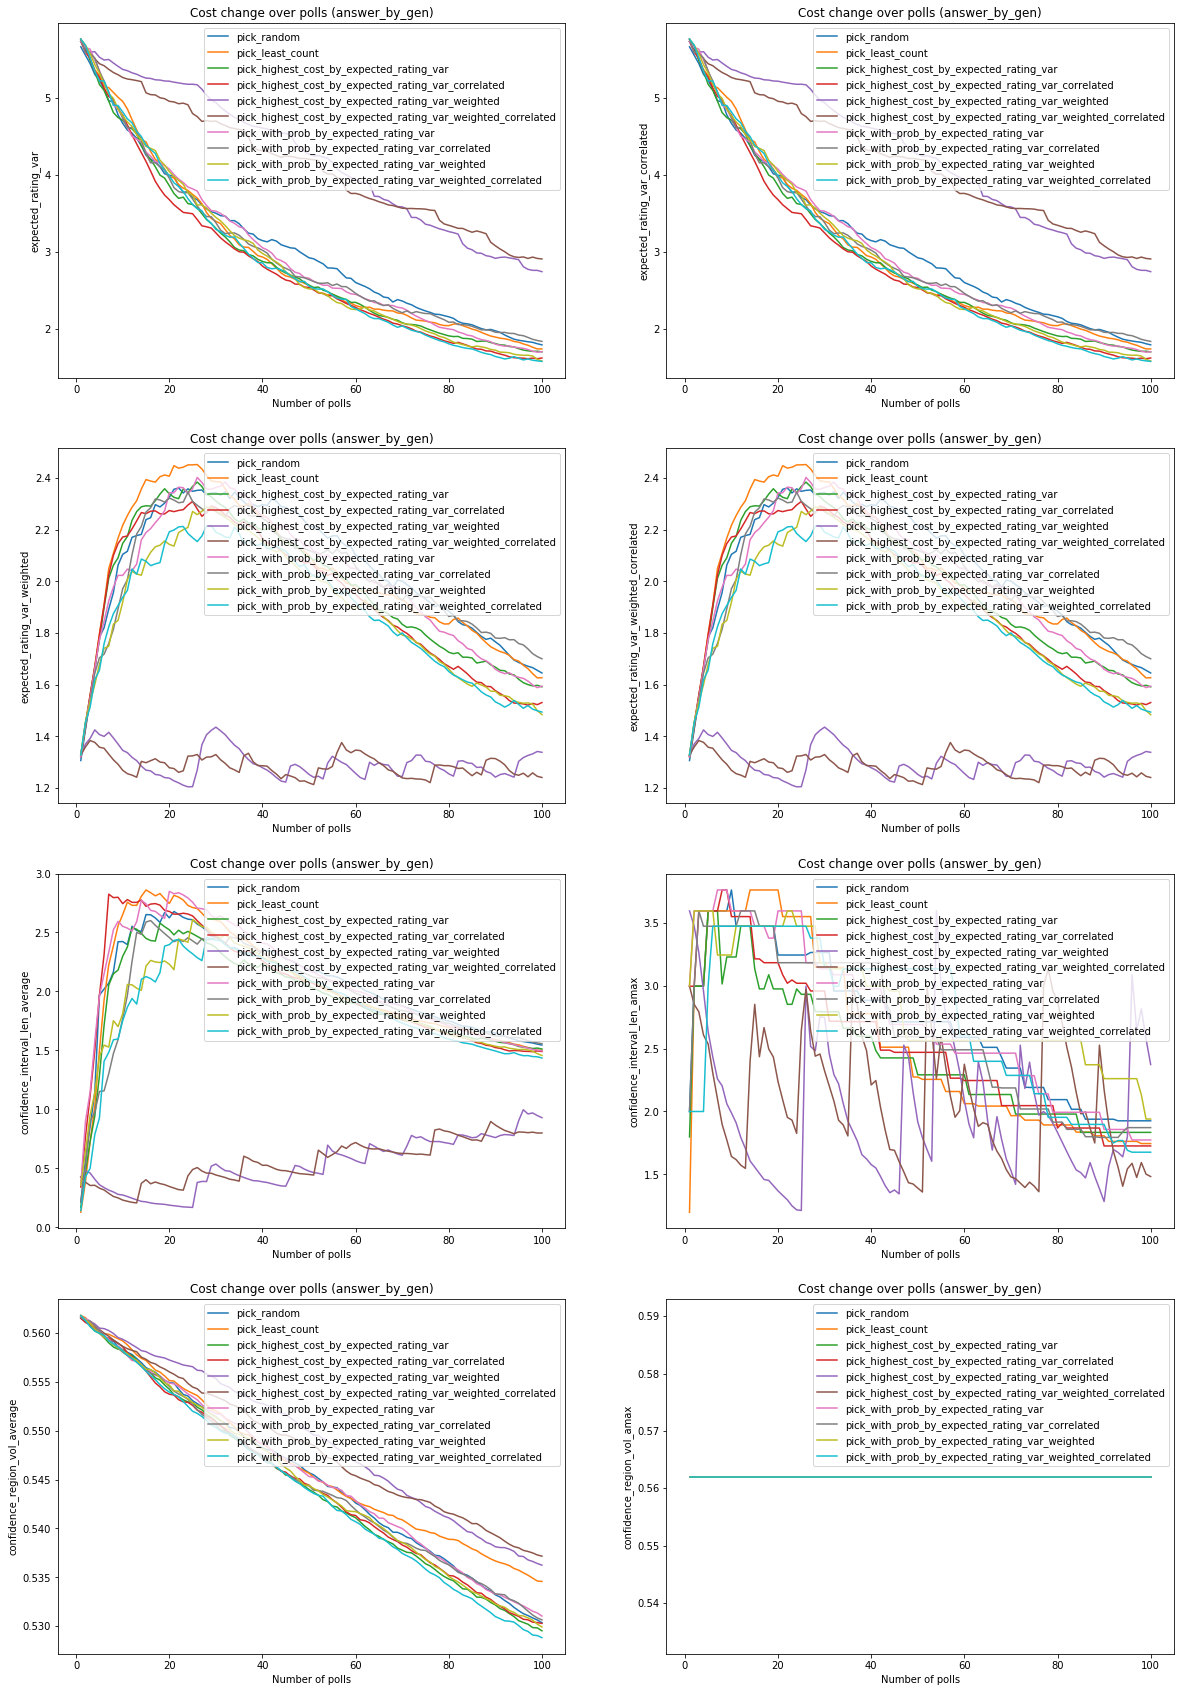

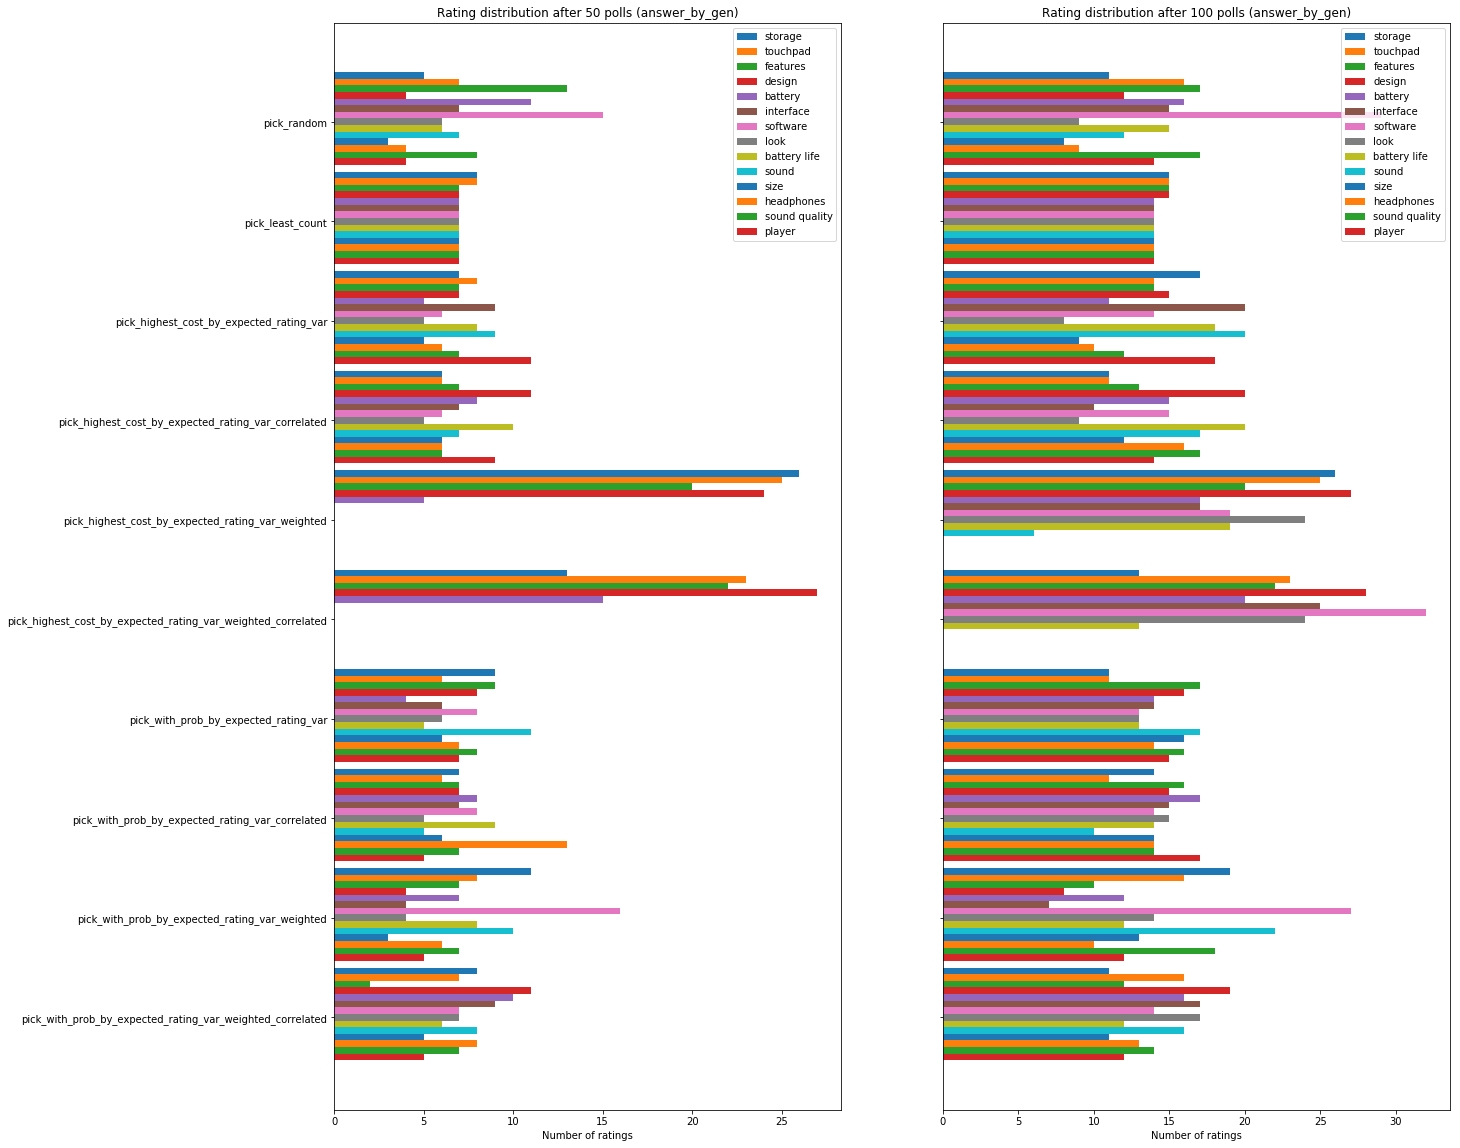

In [99]:
bliu_pdf = PdfPages('plots/bliu_p100.pdf')
bliu_result_paths = ['output/bliu_l100_p100_q2_2.pickle']
path_to_product_stats = OrderedDict()
for path in bliu_result_paths:
    with open(path, 'rb') as f:
        product_to_config_stats = pickle.load(f)
        path_to_product_stats[path] = product_to_config_stats

for path, product_to_stats in path_to_product_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    goal_to_stats_average = soli_start.summary_product_to_config_stats(
        product_to_stats, ignore_rating=True)
    fig = plot_pick_answer_goals(
        goal_to_stats_average, dataset="bliu", poll_max=150, fig_h=30)
    fig.suptitle('Average over all products', fontsize=15, fontweight='bold')
    bliu_pdf.savefig(fig)

for path, product_to_stats in path_to_product_stats.items():
    print('------------------------{}------------------------\n'.format(path))
    for product, goal_to_stats in product_to_stats.items():
        fig = plot_pick_answer_goals(goal_to_stats, poll_max=150, fig_h=30, dataset='bliu')
        fig.suptitle(product, fontsize=15, fontweight='bold')
        bliu_pdf.savefig(fig)
        bliu_pdf.savefig(
            plot_ratings(
                goal_to_stats, dataset="bliu", polls=[50, 100], fig_h=20))
        
bliu_pdf.close()